In [1]:
import torch

torch.manual_seed(1)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm
import warnings

In [2]:
def f(x):
    return (
        torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2


lb = 0
ub = 2
num_queries = 20

bounds = torch.tensor([[lb, lb], [ub, ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs, indexing="ij")
xs = torch.vstack((x1.flatten(), x2.flatten())).transpose(-1, -2)
ys = f(xs)

In [3]:
def visualize_progress_and_policy(policy, next_x=None):
    with torch.no_grad():
        acquisition_score = policy(xs.unsqueeze(1))

    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # ground truth
    c = ax[0].imshow(ys.reshape(101, 101).T, origin="lower", extent=[lb, ub, lb, ub])
    ax[0].set_xlabel(r"$C$", fontsize=20)
    ax[0].set_ylabel(r"$\gamma$", fontsize=20)
    plt.colorbar(c, ax=ax[0])

    ax[0].scatter(train_x[..., 0], train_x[..., 1], marker="x", c="k")

    ax[0].set_title("ground truth")

    # acquisition score
    c = ax[1].imshow(
        acquisition_score.reshape(101, 101).T, origin="lower", extent=[lb, ub, lb, ub]
    )
    ax[1].set_xlabel(r"$C$", fontsize=20)
    plt.colorbar(c, ax=ax[1])

    ax[1].scatter(
        train_x[..., 0], train_x[..., 1], marker="x", c="k", label="observations"
    )
    if next_x is not None:
        ax[1].scatter(
            next_x[..., 0], next_x[..., 1], c="r", marker="*", s=500, label="next query"
        )

    ax[1].legend()
    ax[1].set_title("acq. score")

    plt.show()

In [4]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [5]:
train_x = torch.tensor(
    [
        [1.0, 1.0],
    ]
)
train_y = f(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

model, likelihood = fit_gp_model(train_x, train_y)

tensor([[1.0000, 1.0000, 0.3800]])


# PoI

iteration 0
incumbent tensor([1., 1.]) tensor(0.3800)


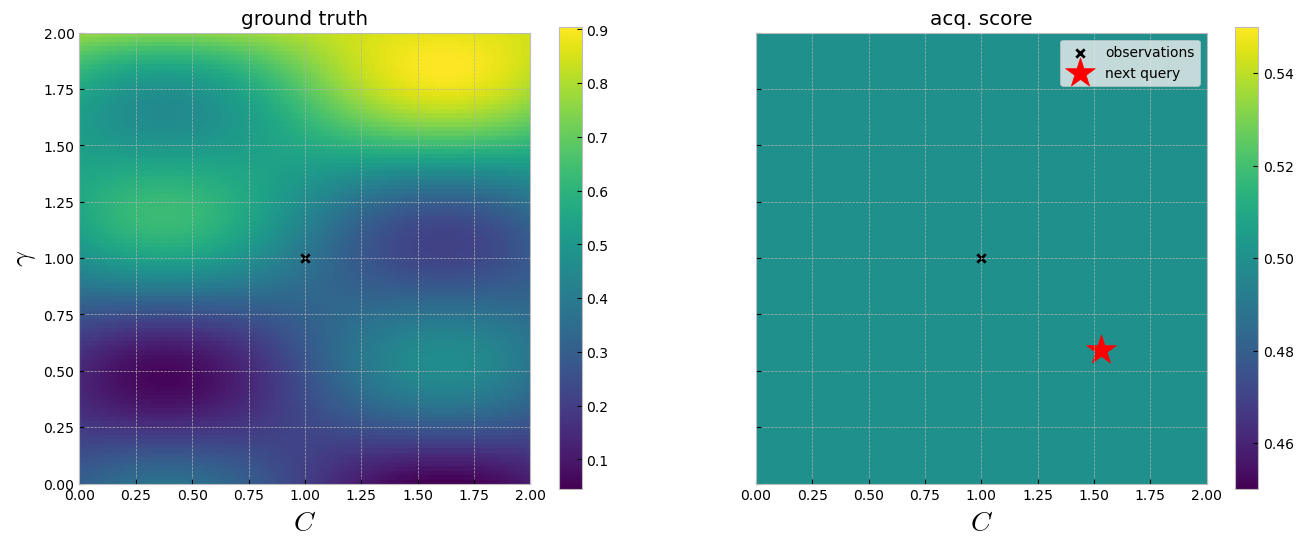

iteration 1
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


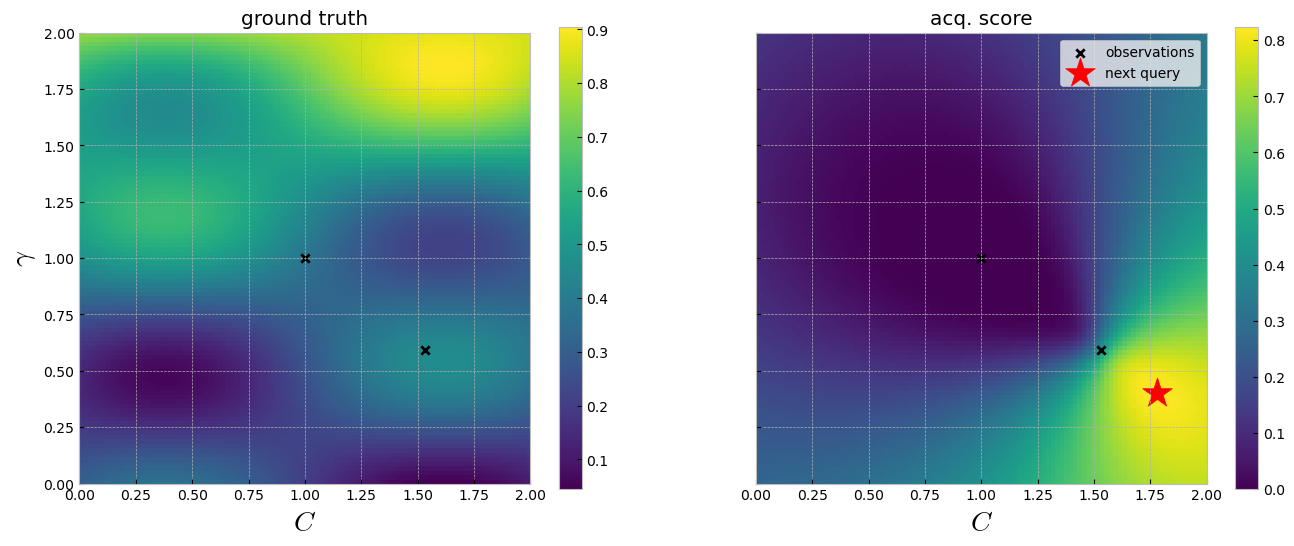

iteration 2
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


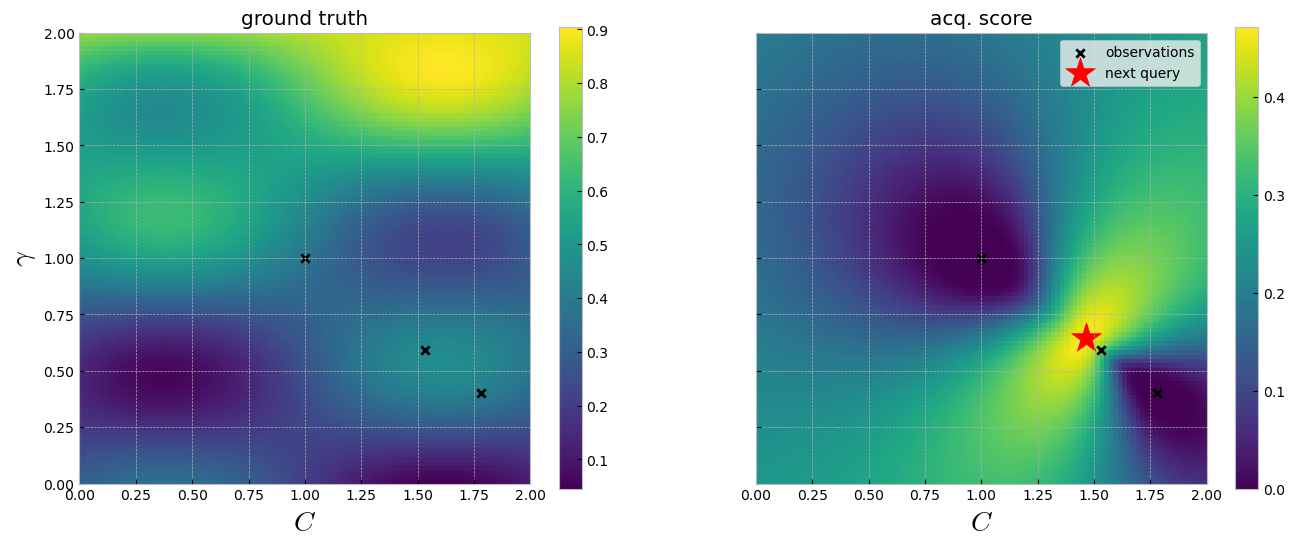

iteration 3
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


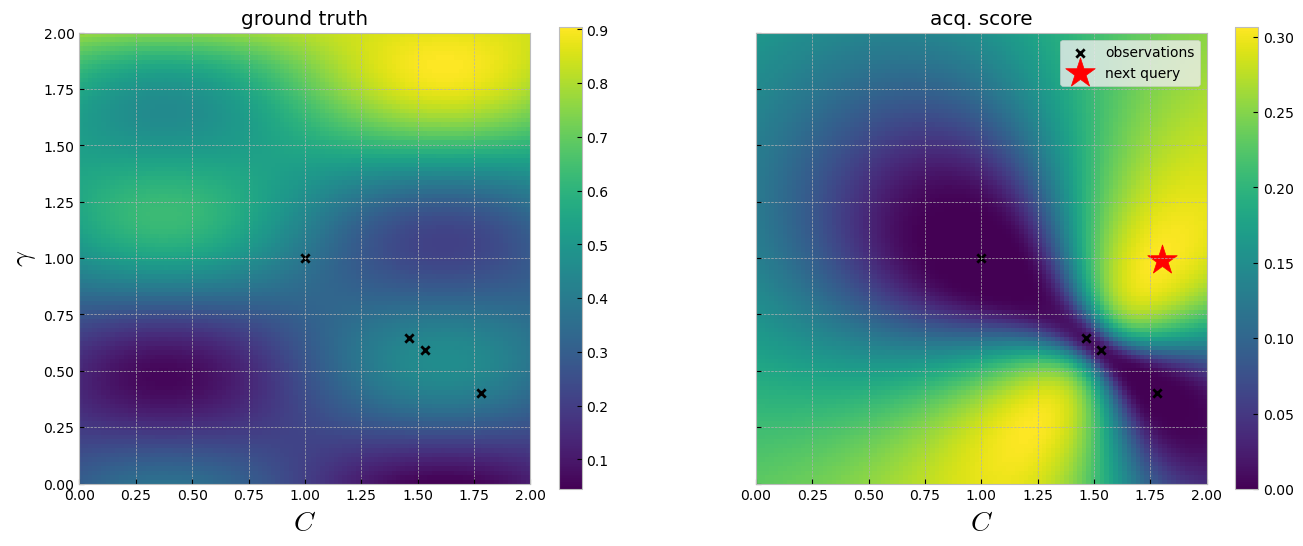

iteration 4
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


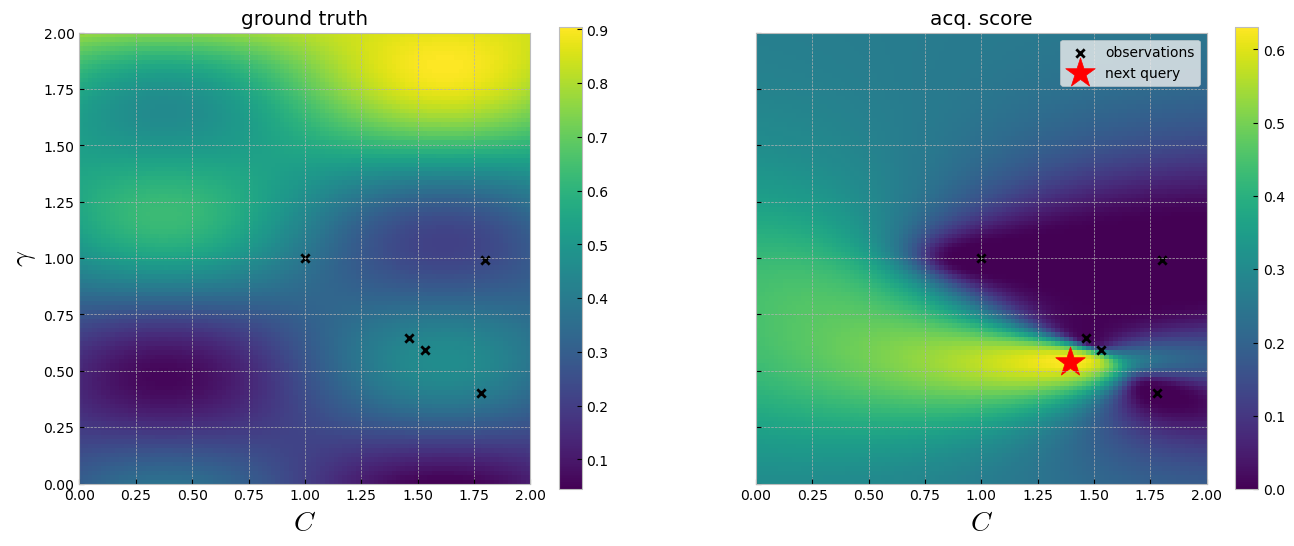

iteration 5
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


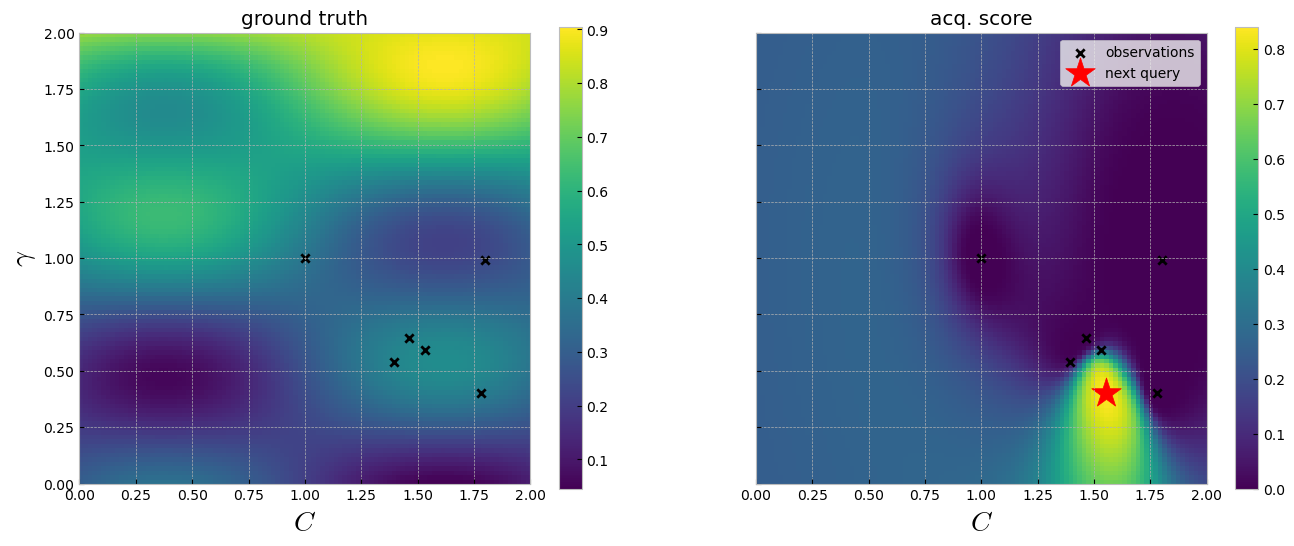

iteration 6
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


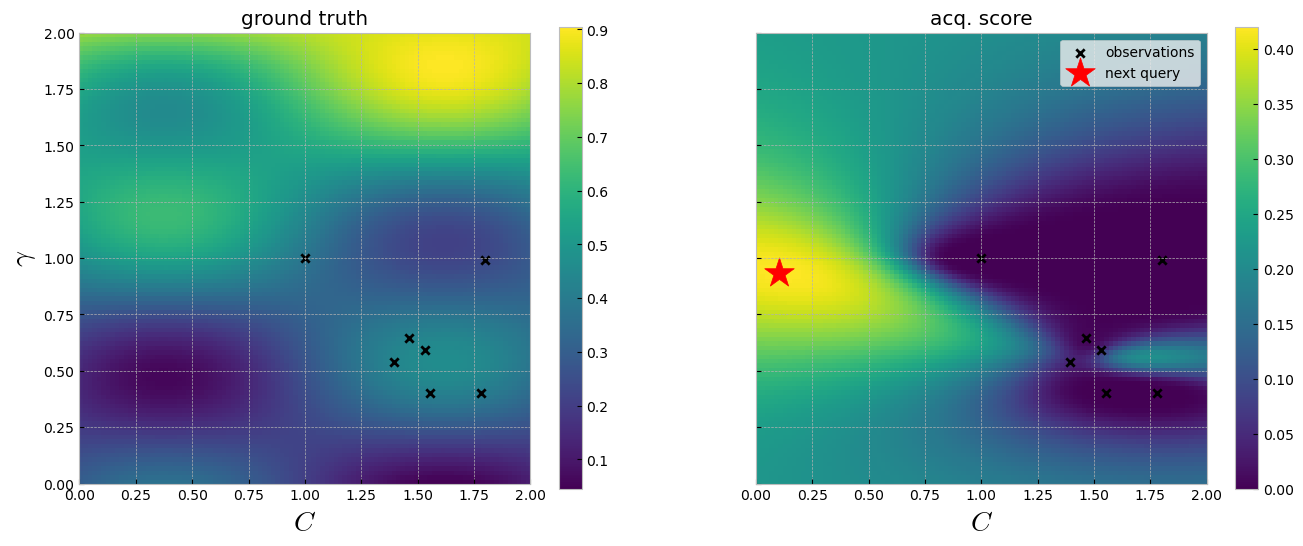

iteration 7
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:374: RuntimeWarning: Optimization failed on the second try, after generating a new set of initial conditions.
  warnings.warn(


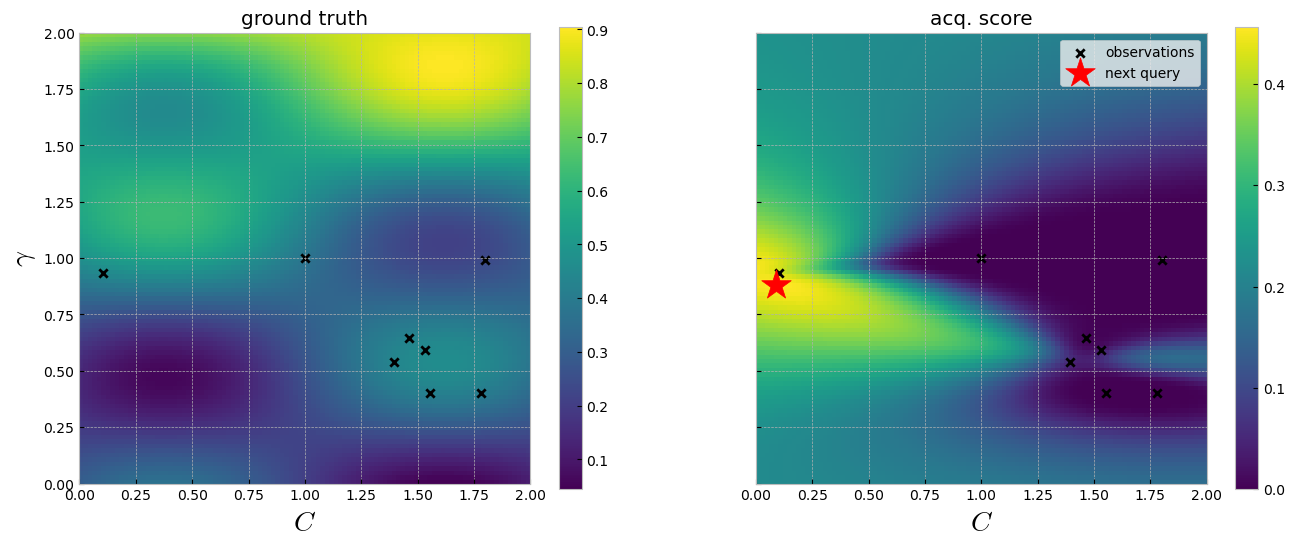

iteration 8
incumbent tensor([1.5327, 0.5908]) tensor(0.4528)


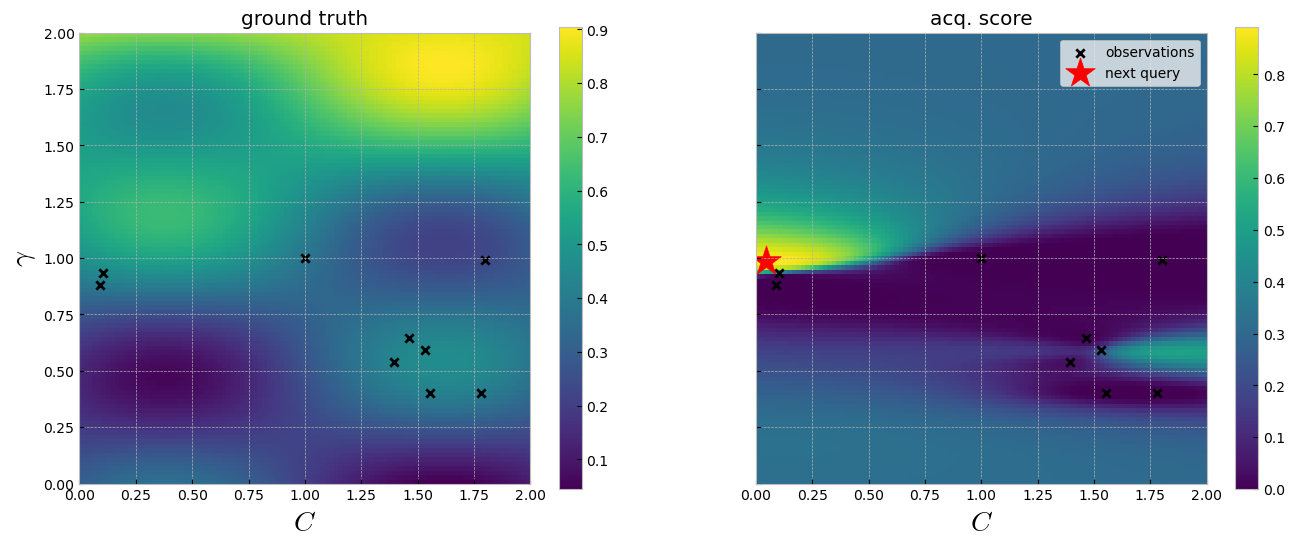

iteration 9
incumbent tensor([0.0470, 0.9887]) tensor(0.4821)


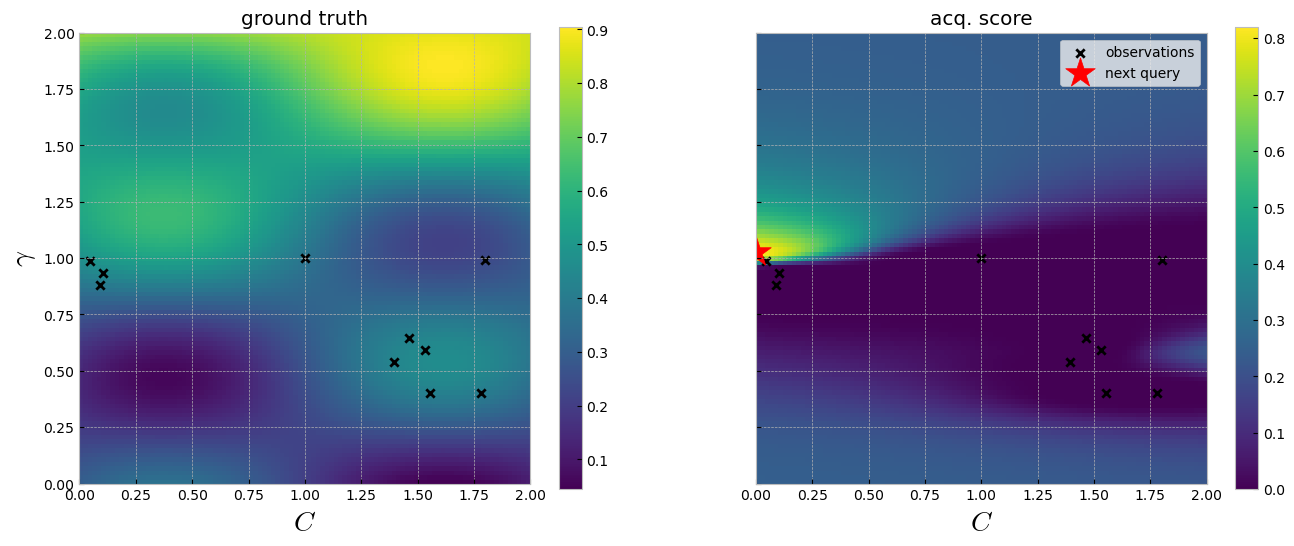

iteration 10
incumbent tensor([0.0000, 1.0273]) tensor(0.4930)


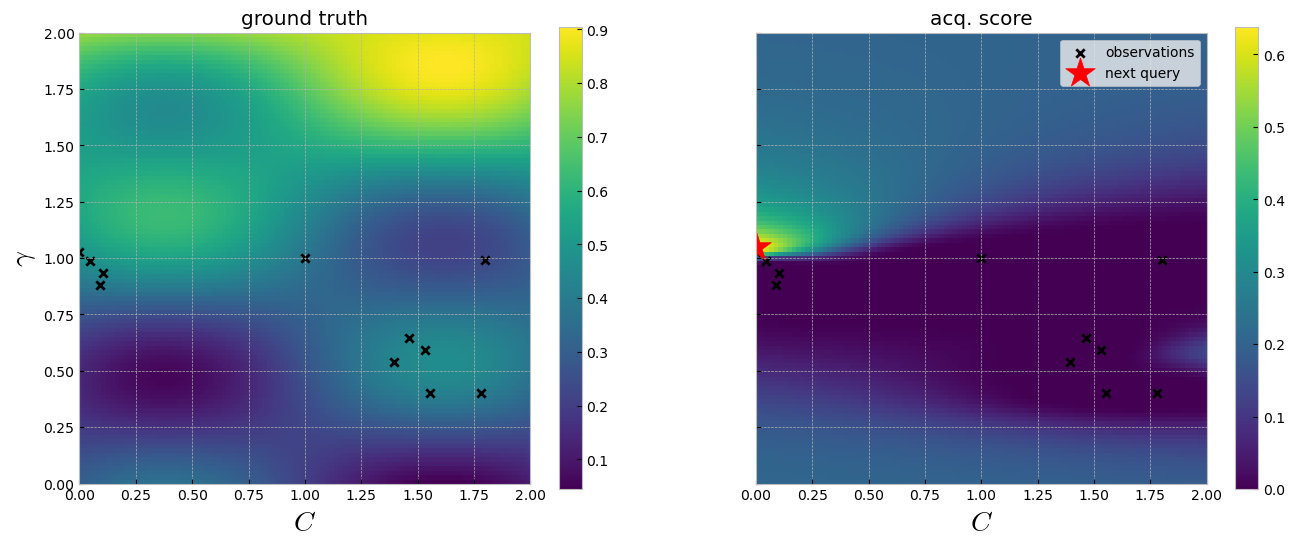

iteration 11
incumbent tensor([0.0000, 1.0492]) tensor(0.5055)


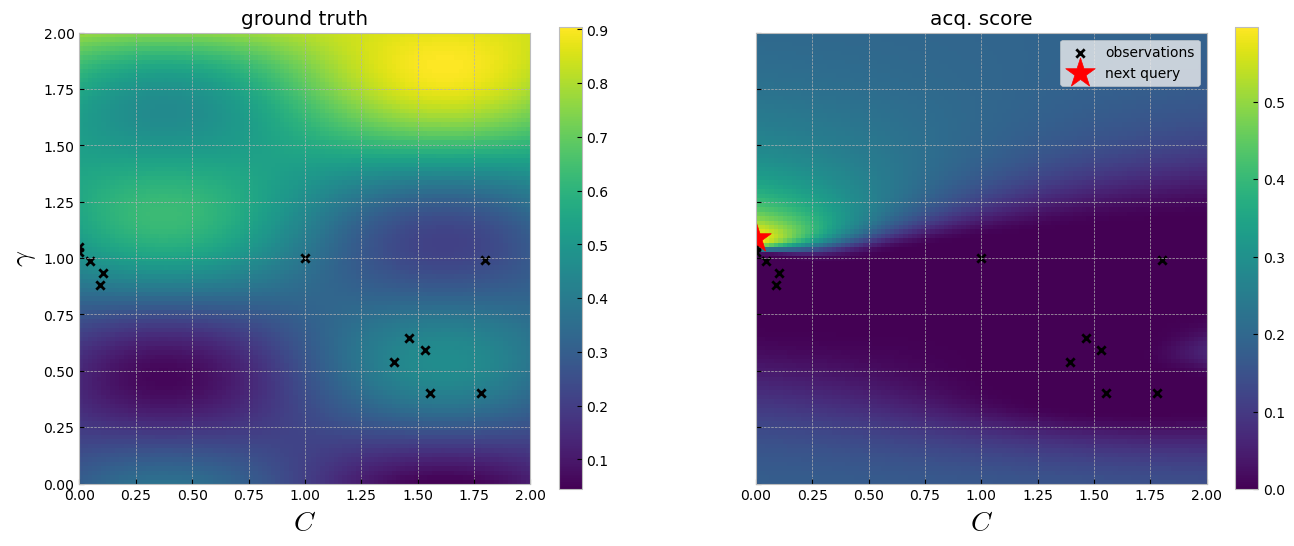

iteration 12
incumbent tensor([0.0000, 1.0894]) tensor(0.5252)


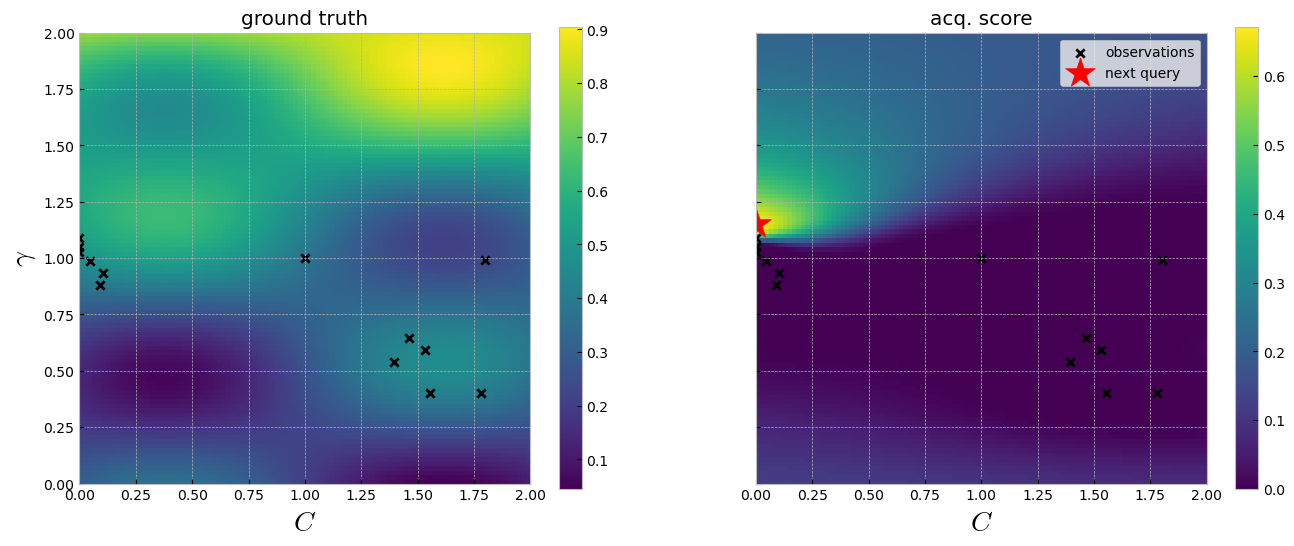

iteration 13
incumbent tensor([0.0000, 1.1495]) tensor(0.5467)


/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


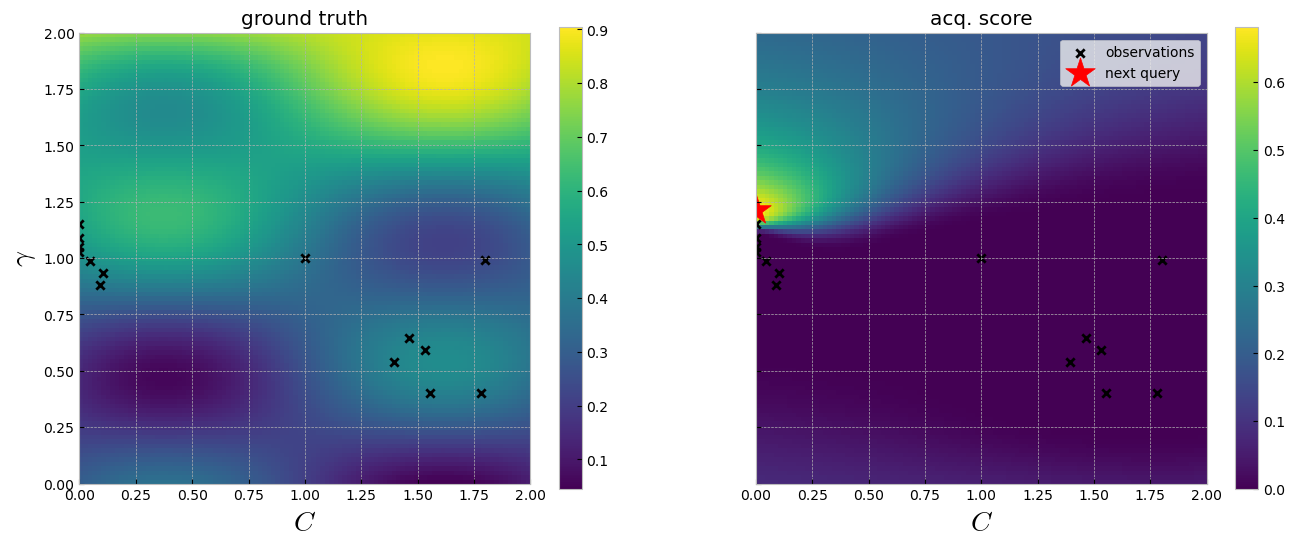

iteration 14
incumbent tensor([0.0000, 1.2118]) tensor(0.5586)


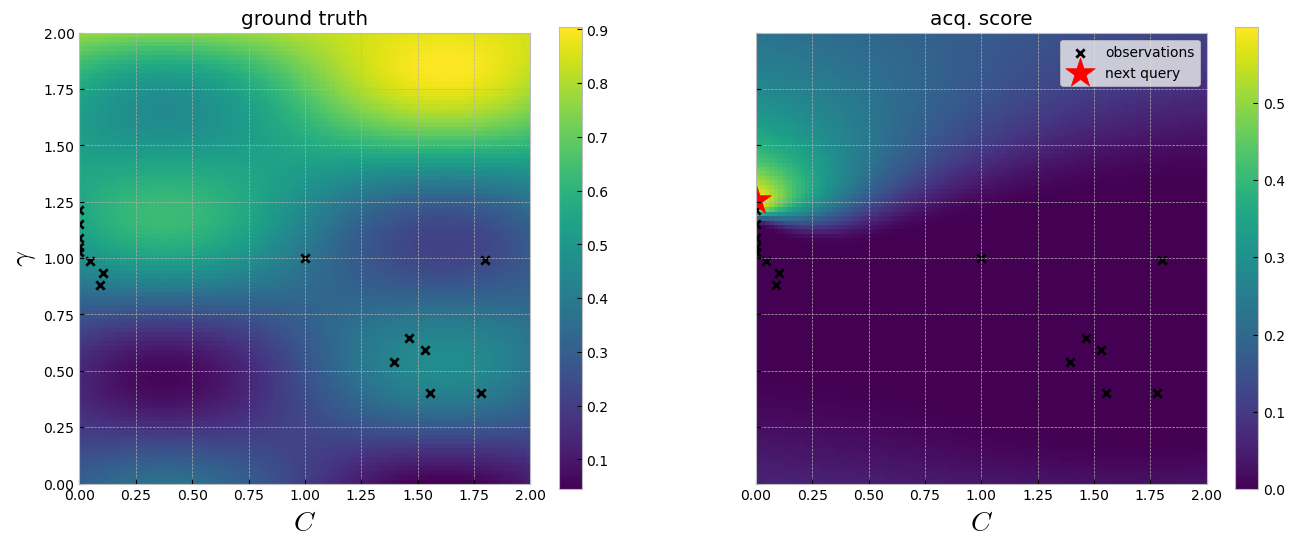

iteration 15
incumbent tensor([0.0000, 1.2579]) tensor(0.5611)


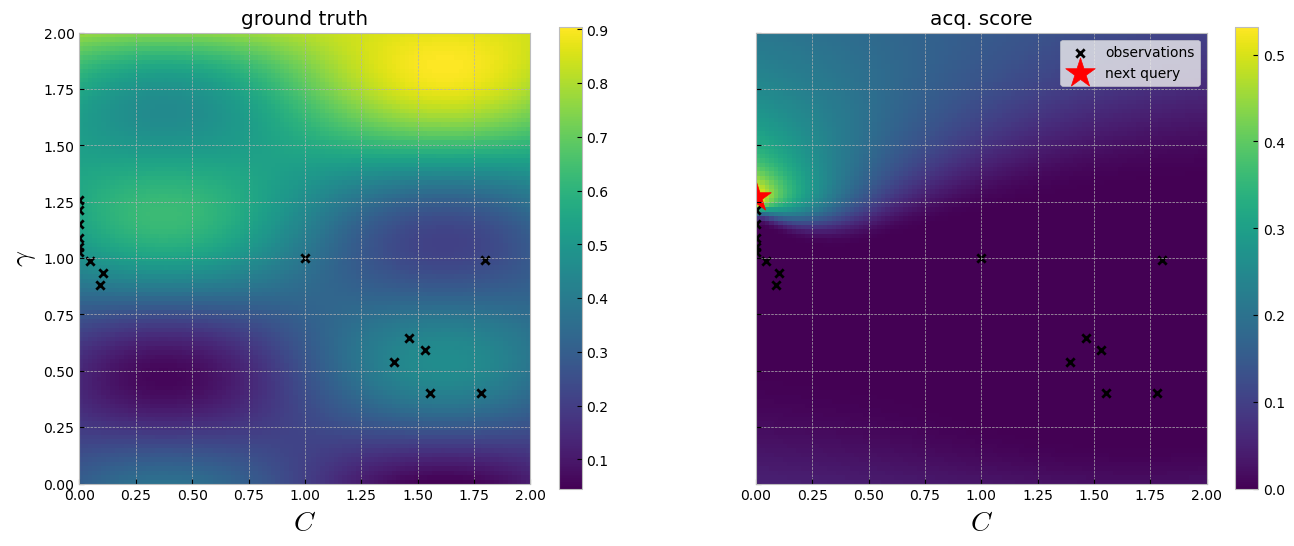

iteration 16
incumbent tensor([0.0000, 1.2579]) tensor(0.5611)


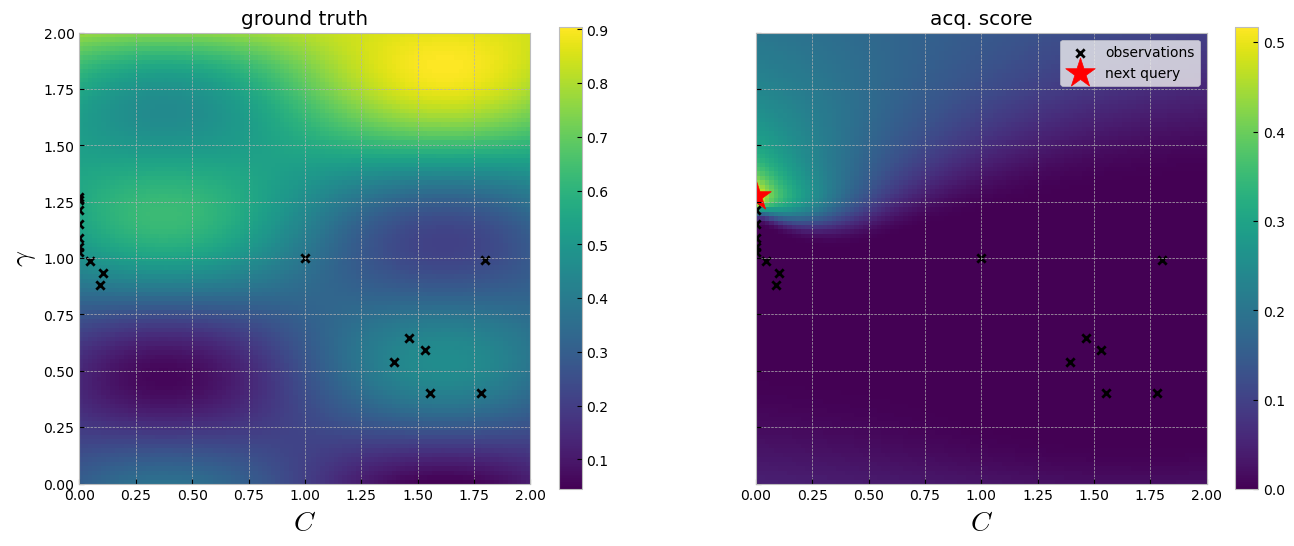

iteration 17
incumbent tensor([0.0000, 1.2579]) tensor(0.5611)


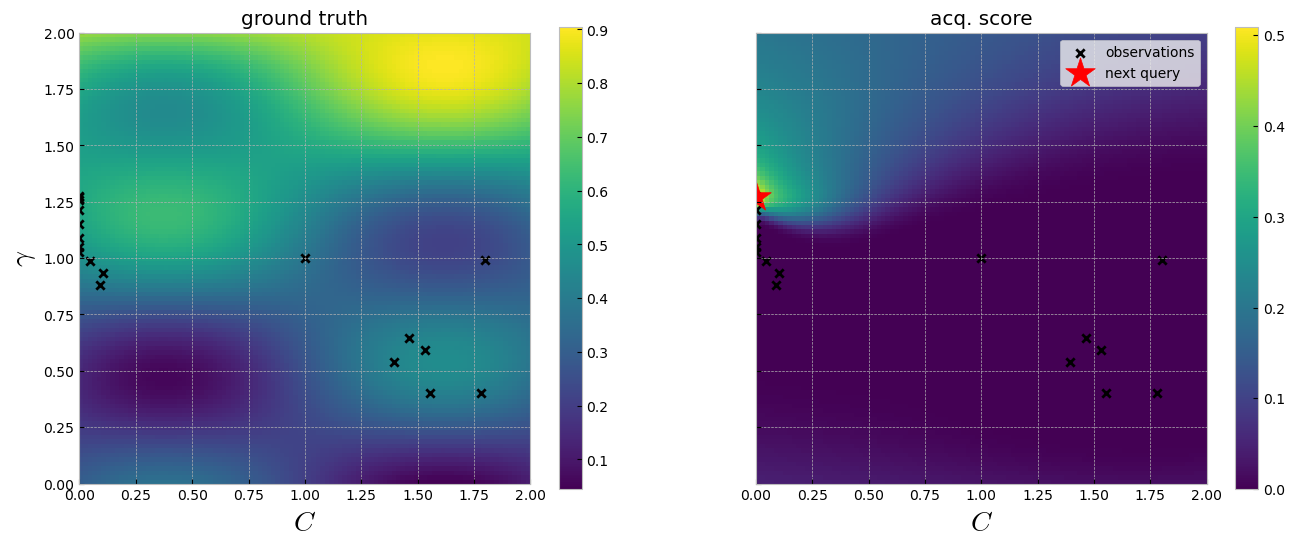

iteration 18
incumbent tensor([0.0000, 1.2579]) tensor(0.5611)


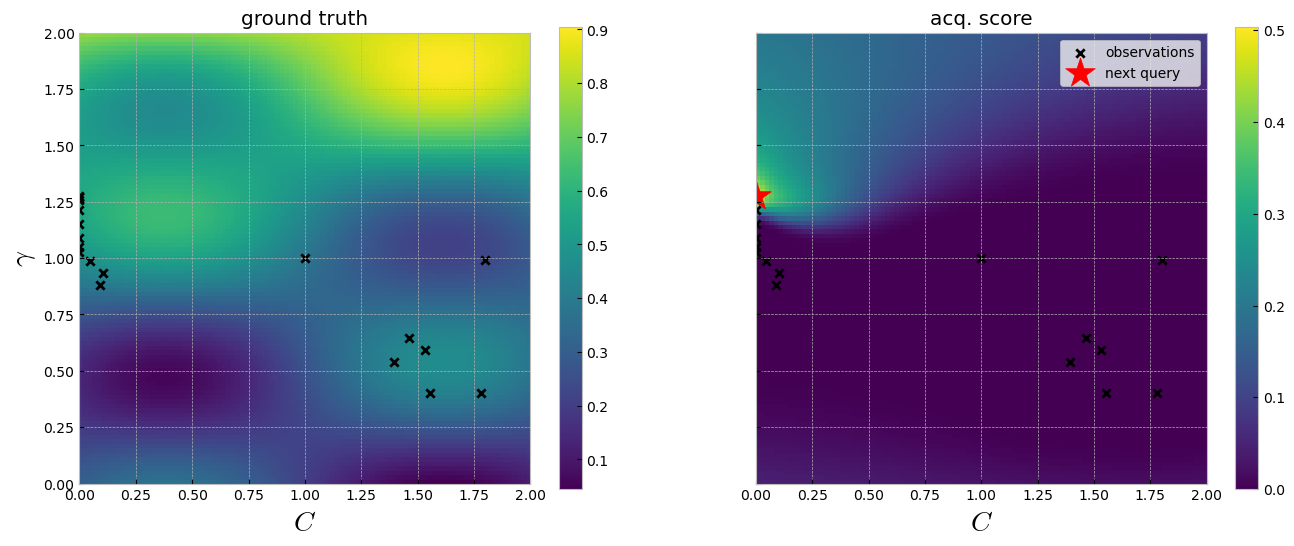

iteration 19
incumbent tensor([0.0000, 1.2579]) tensor(0.5611)


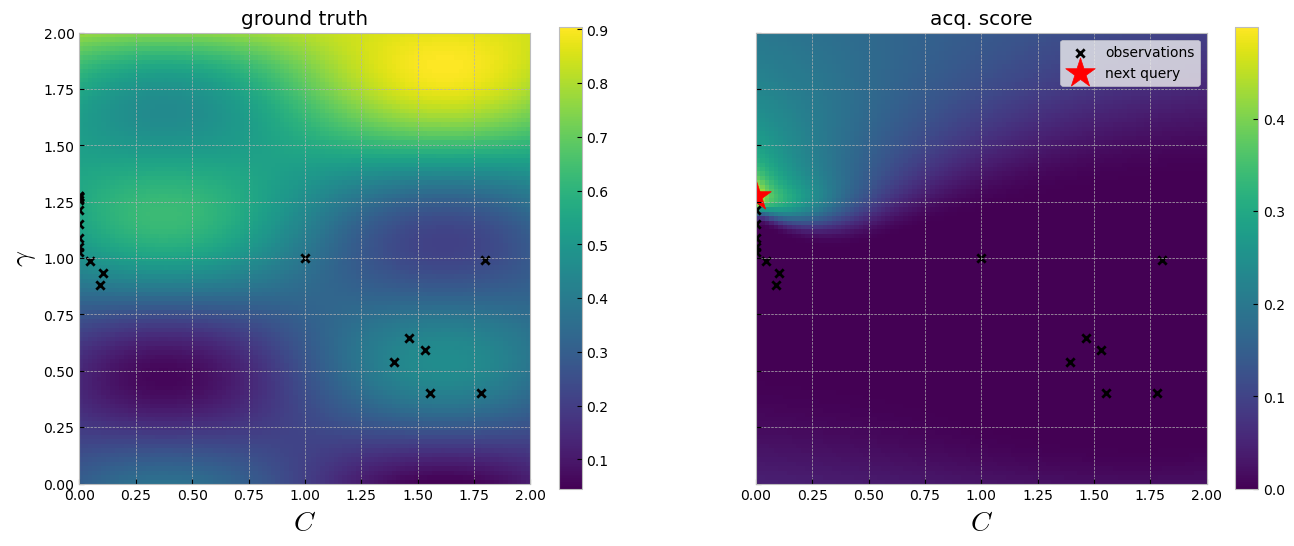

In [6]:
for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100,
    )

    visualize_progress_and_policy(policy, next_x=next_x)

    next_y = f(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

# Modified PoI

iteration 0
incumbent tensor([1., 1.]) tensor(0.3800)


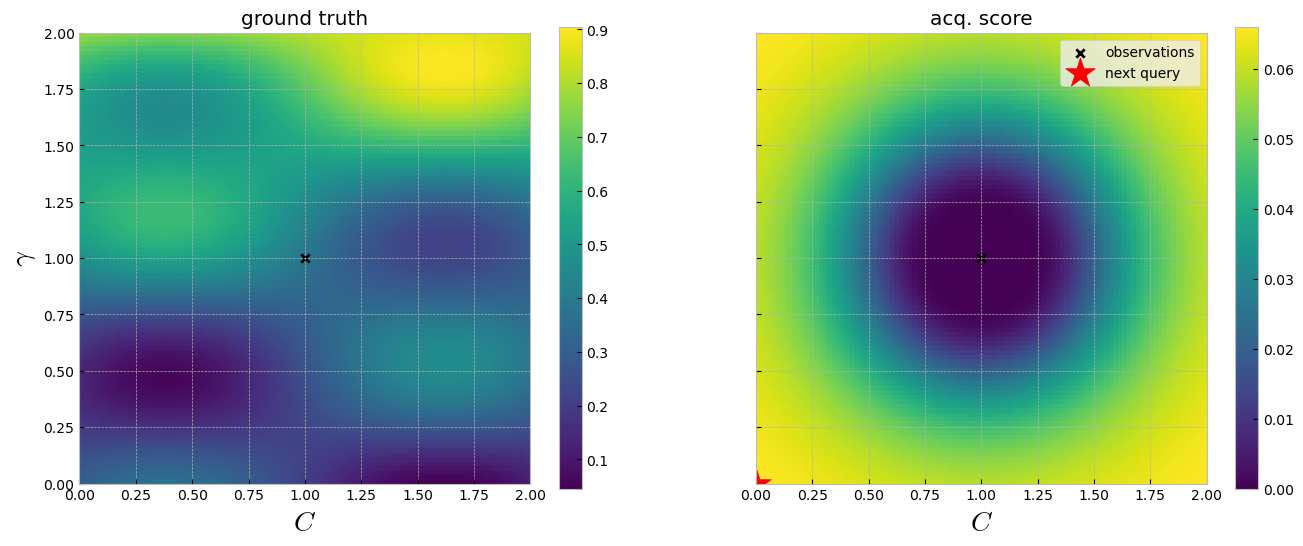

iteration 1
incumbent tensor([1., 1.]) tensor(0.3800)


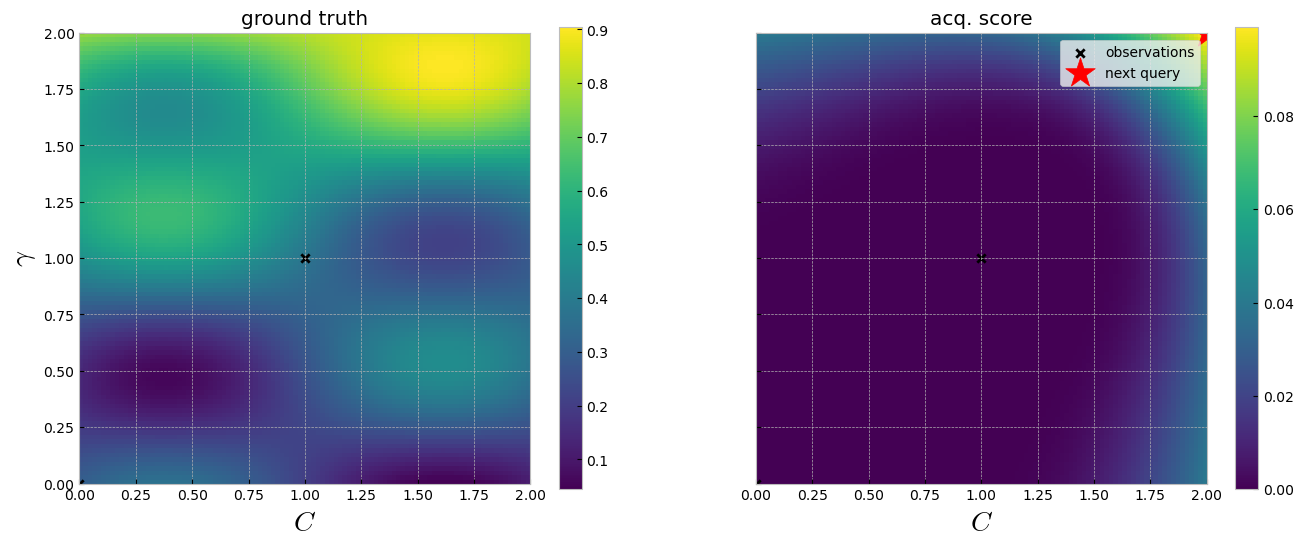

iteration 2
incumbent tensor([2., 2.]) tensor(0.8465)


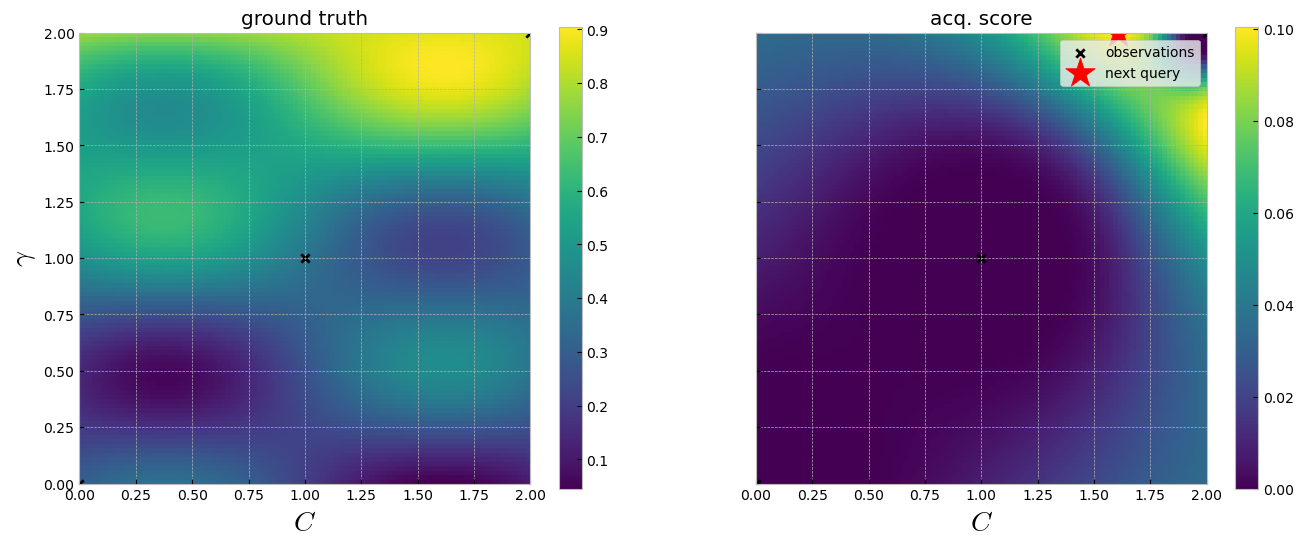

iteration 3
incumbent tensor([1.6048, 2.0000]) tensor(0.8742)


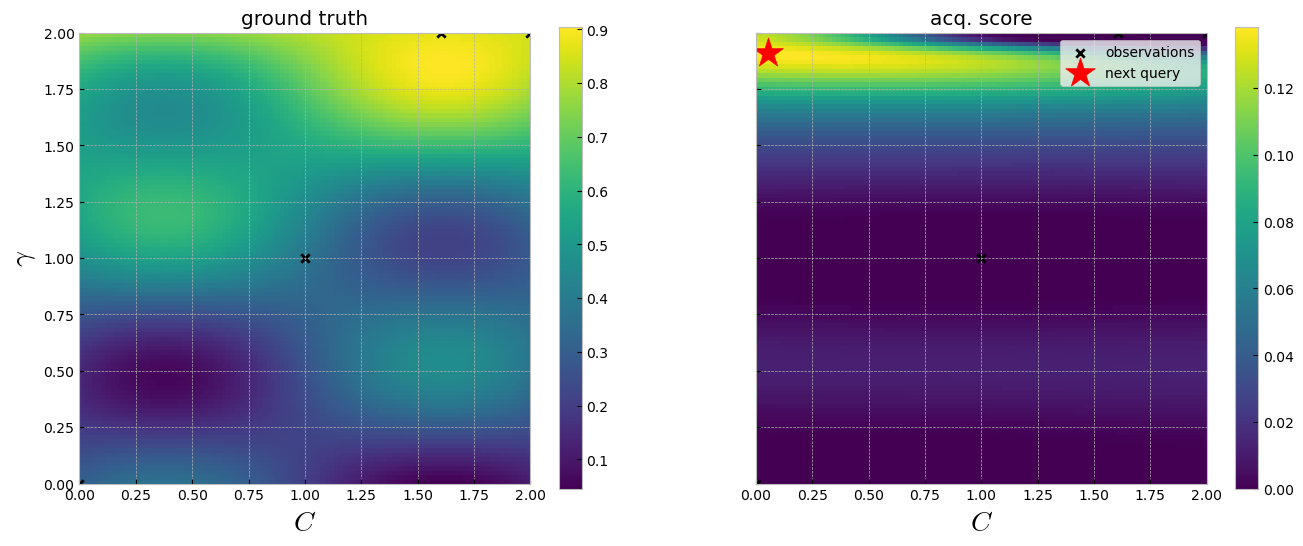

iteration 4
incumbent tensor([1.6048, 2.0000]) tensor(0.8742)


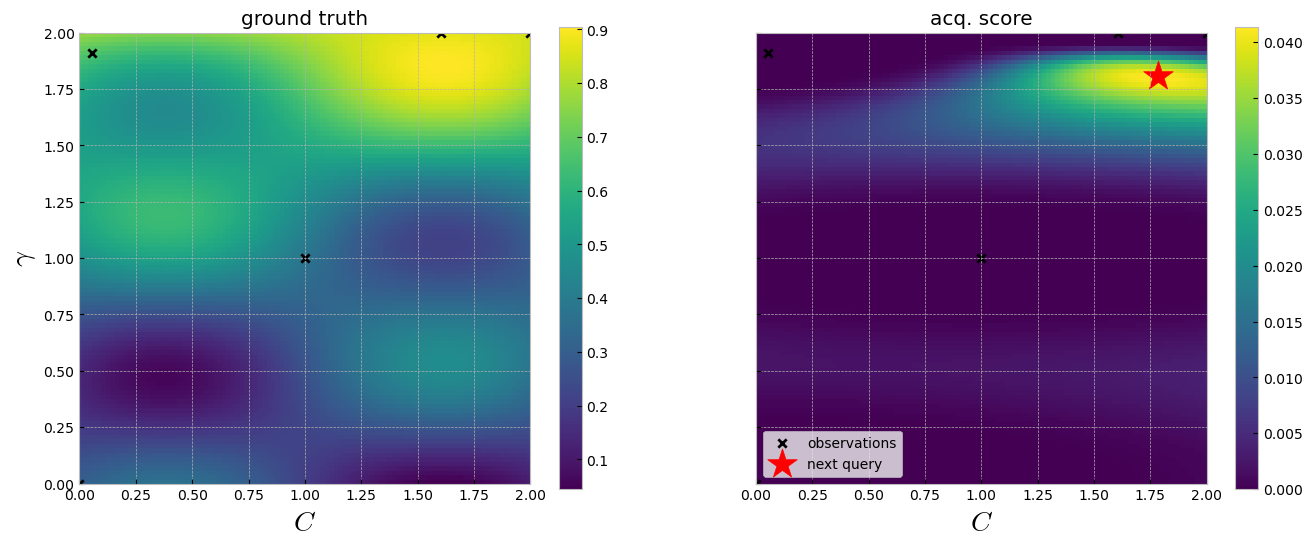

iteration 5
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


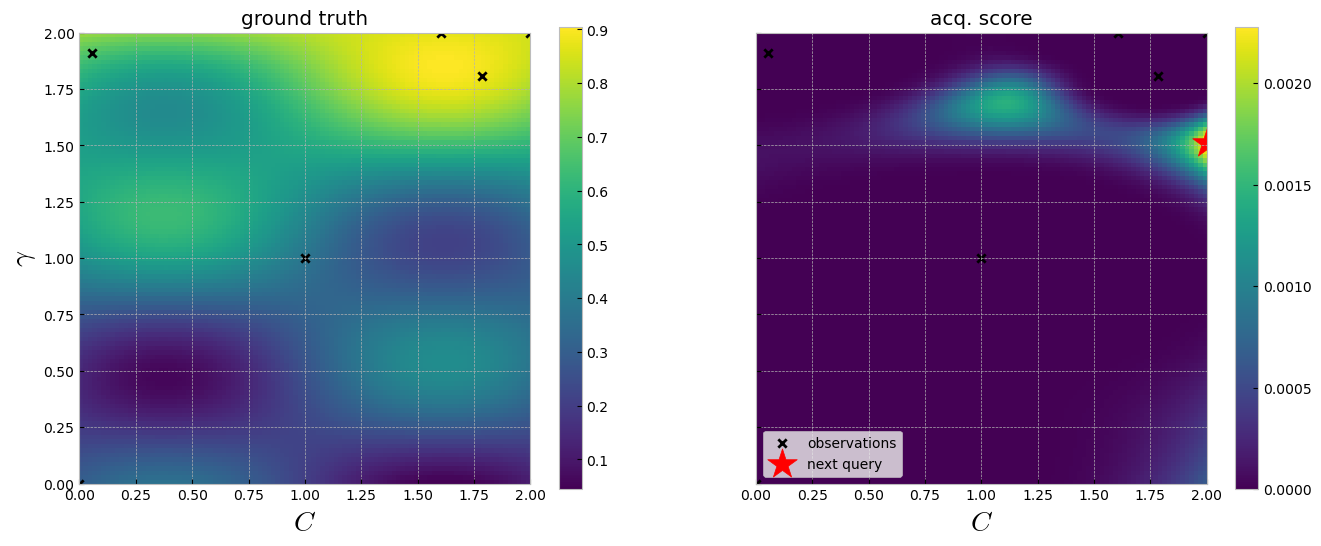

iteration 6
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


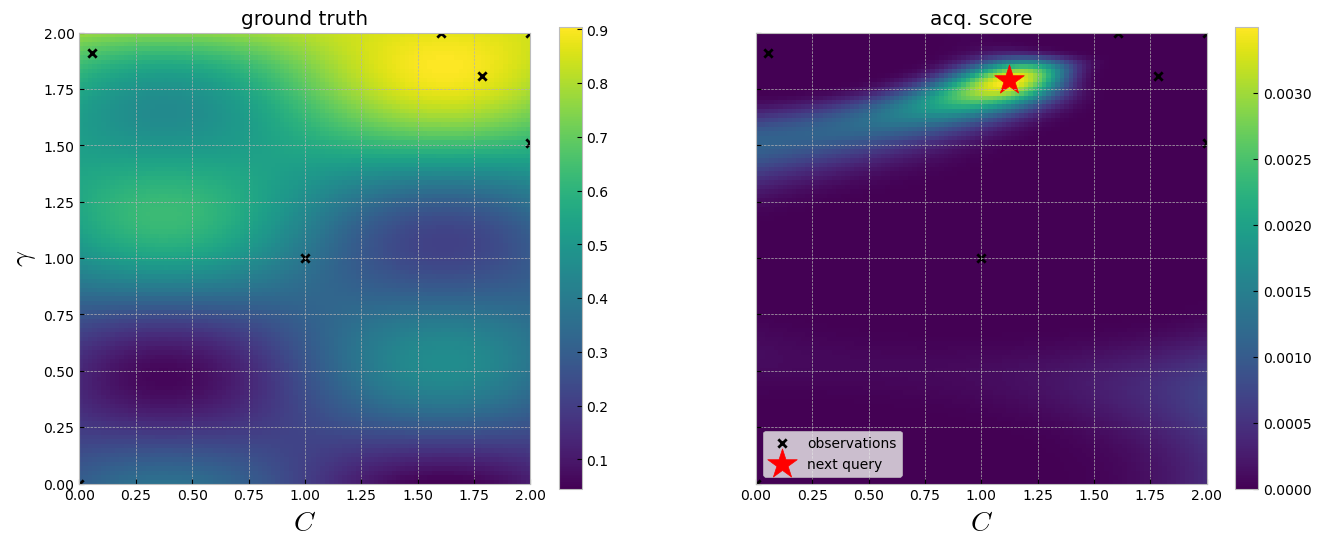

iteration 7
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


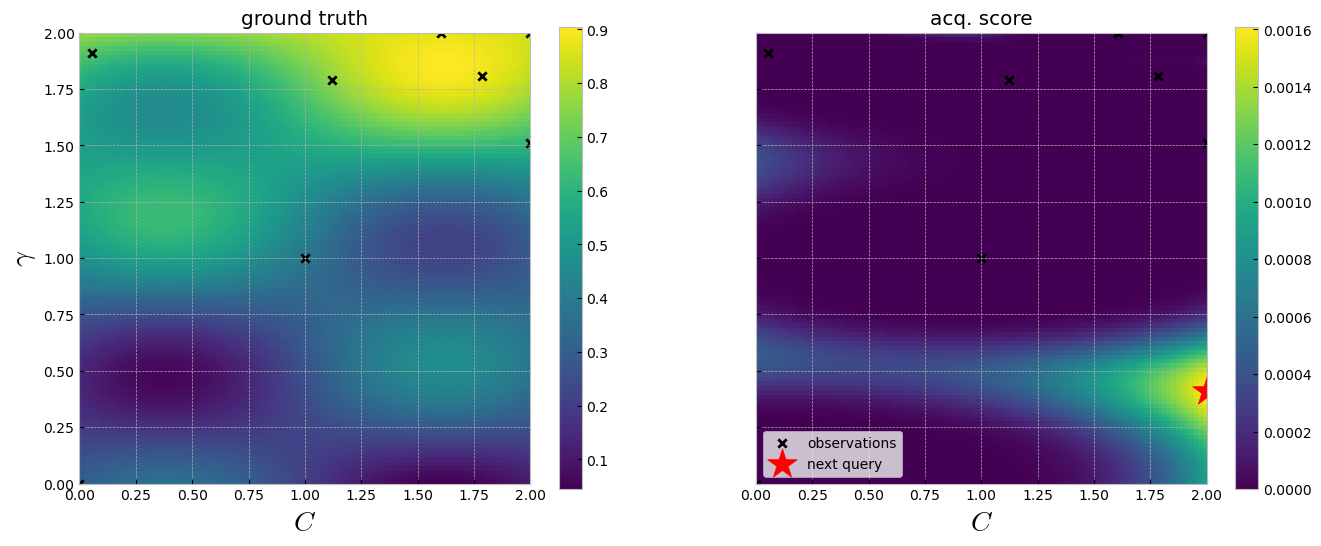

iteration 8
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


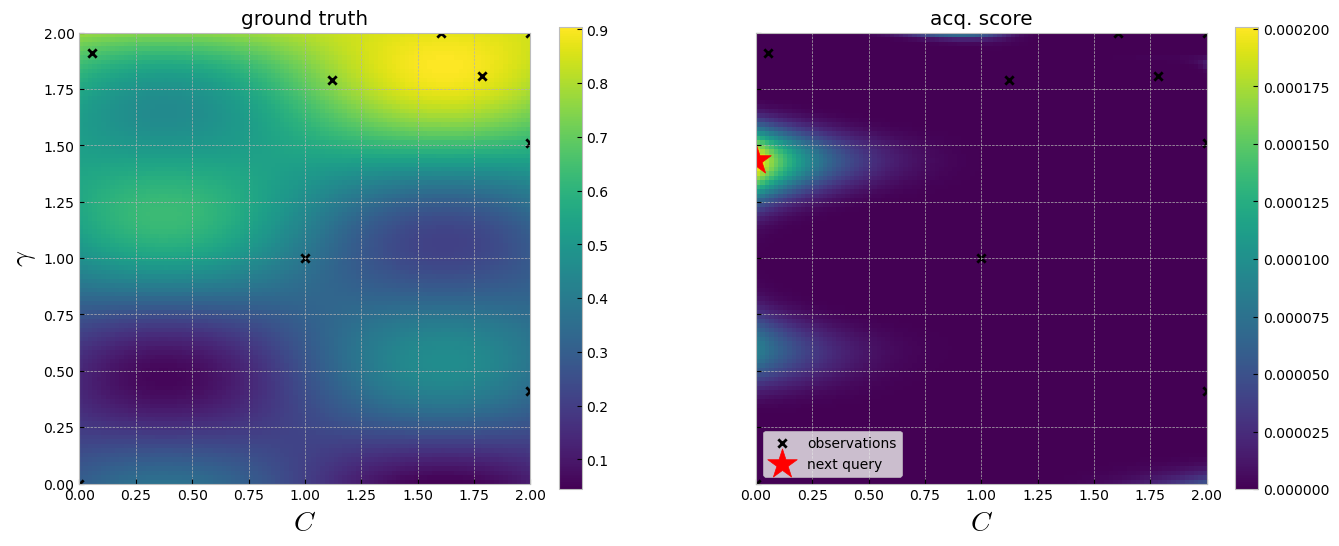

iteration 9
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


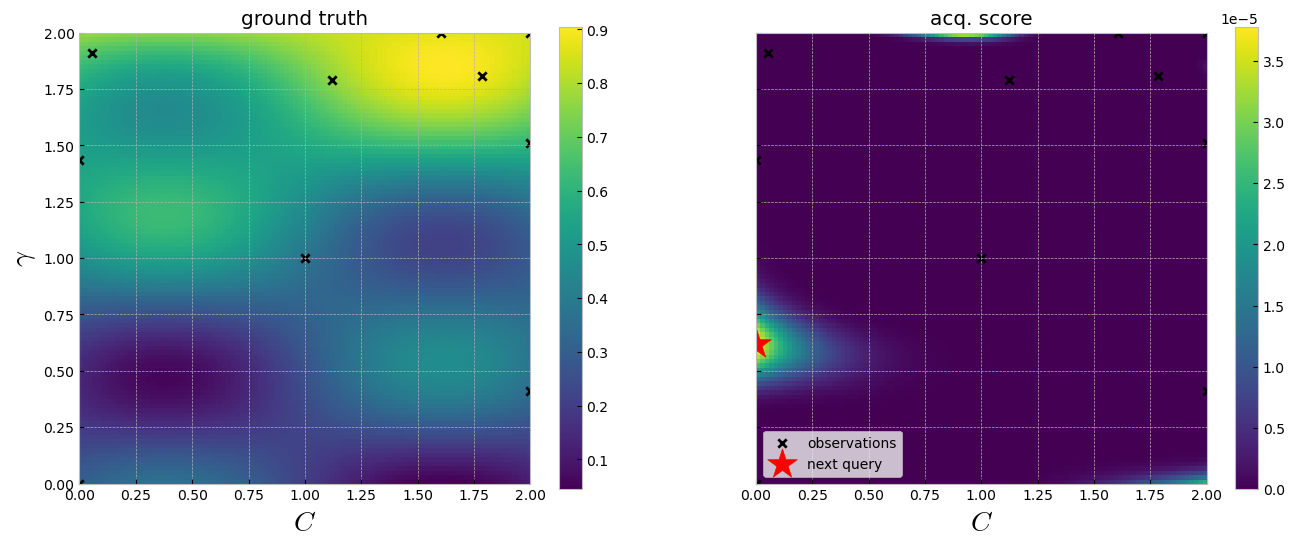

iteration 10
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


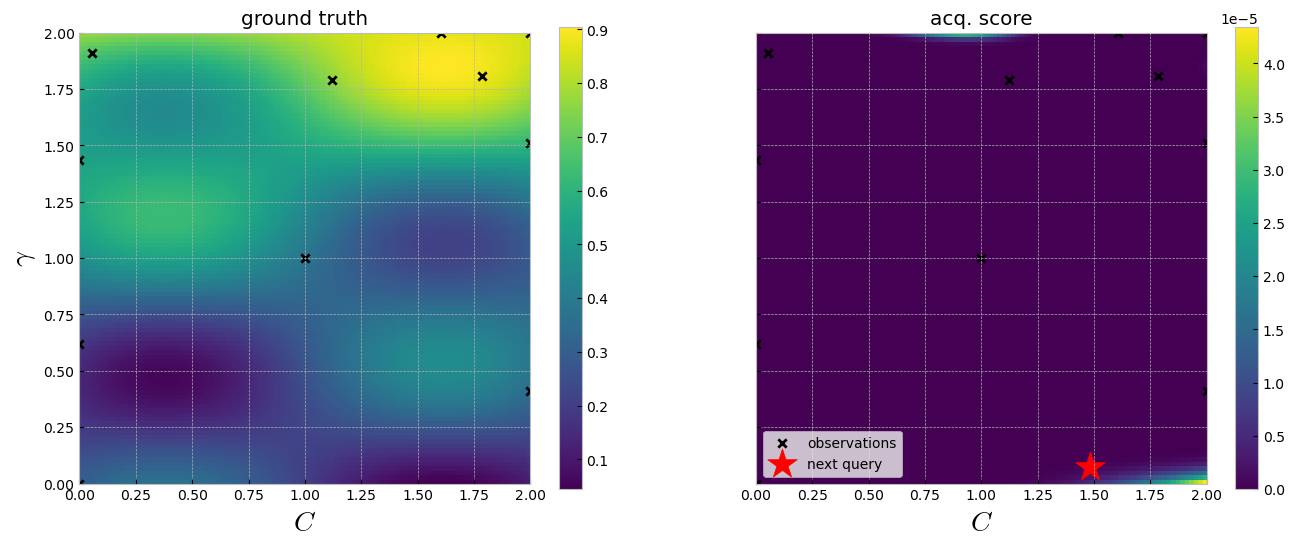

iteration 11
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


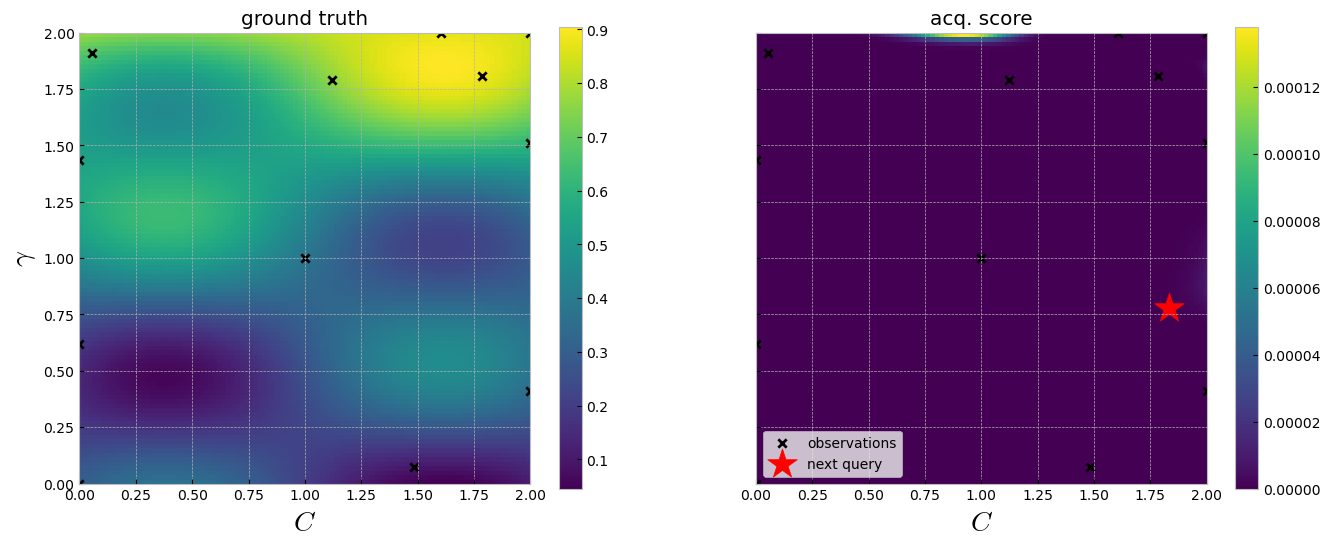

iteration 12
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


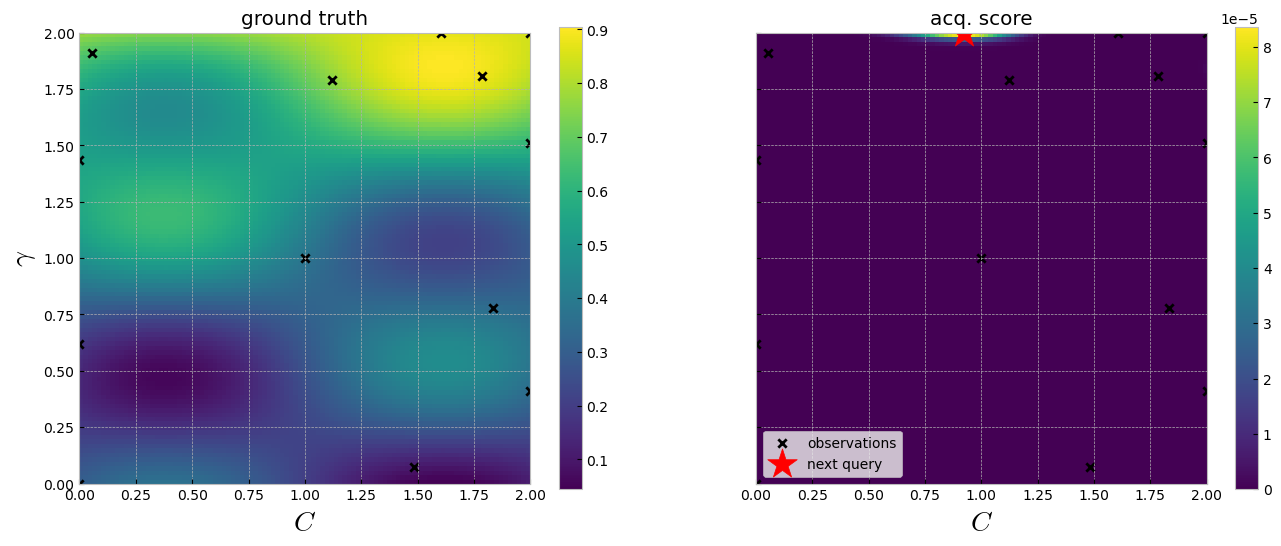

iteration 13
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


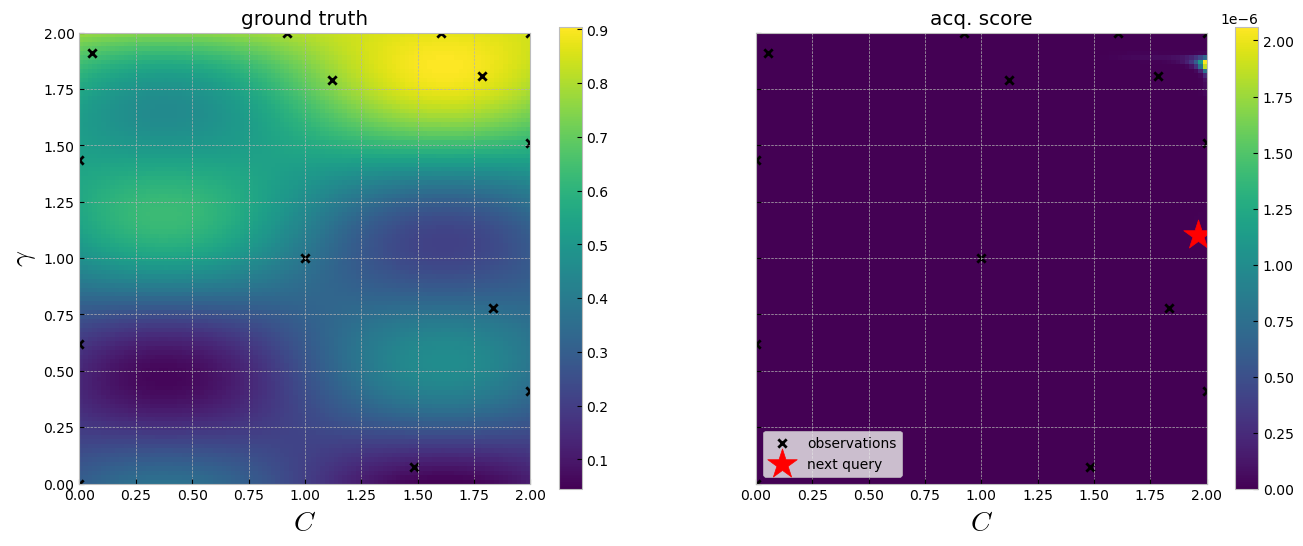

iteration 14
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


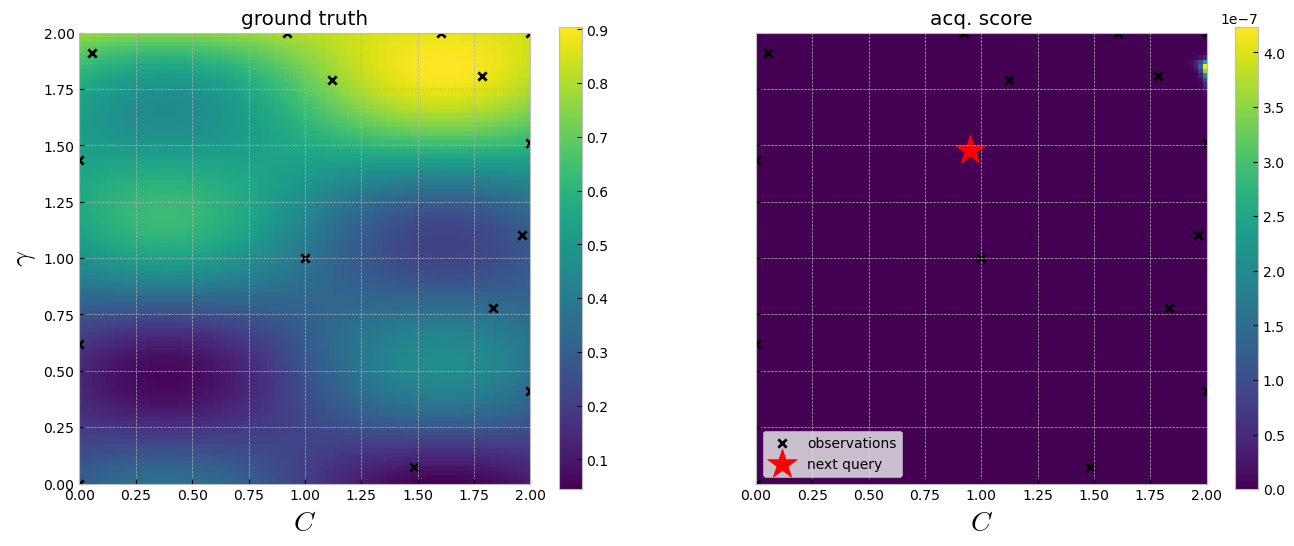

iteration 15
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


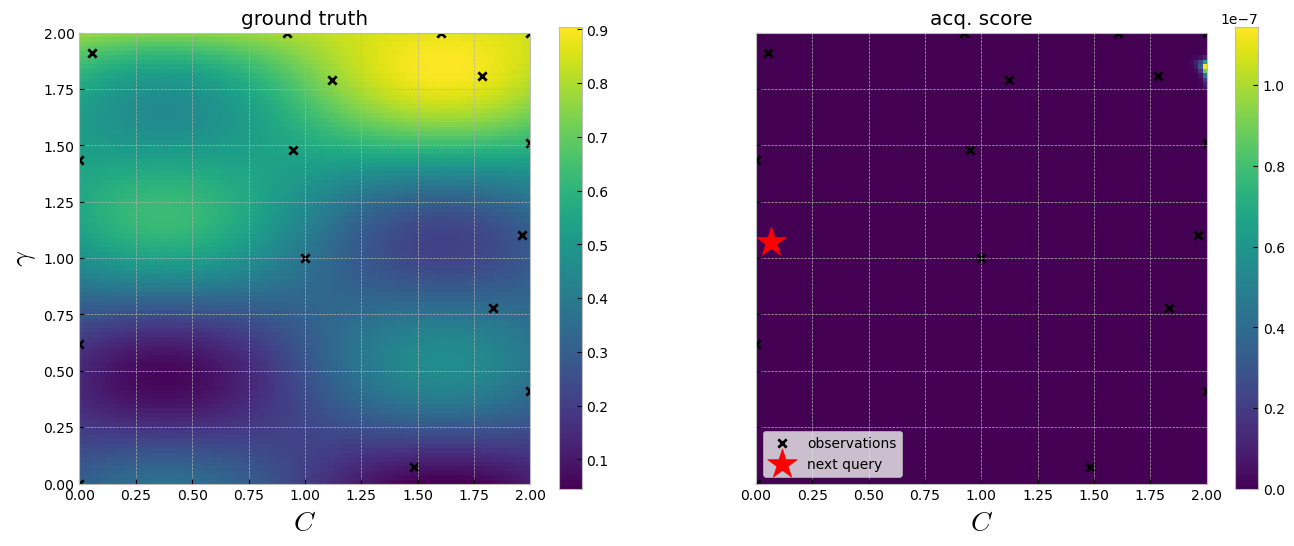

iteration 16
incumbent tensor([1.7851, 1.8084]) tensor(0.8829)


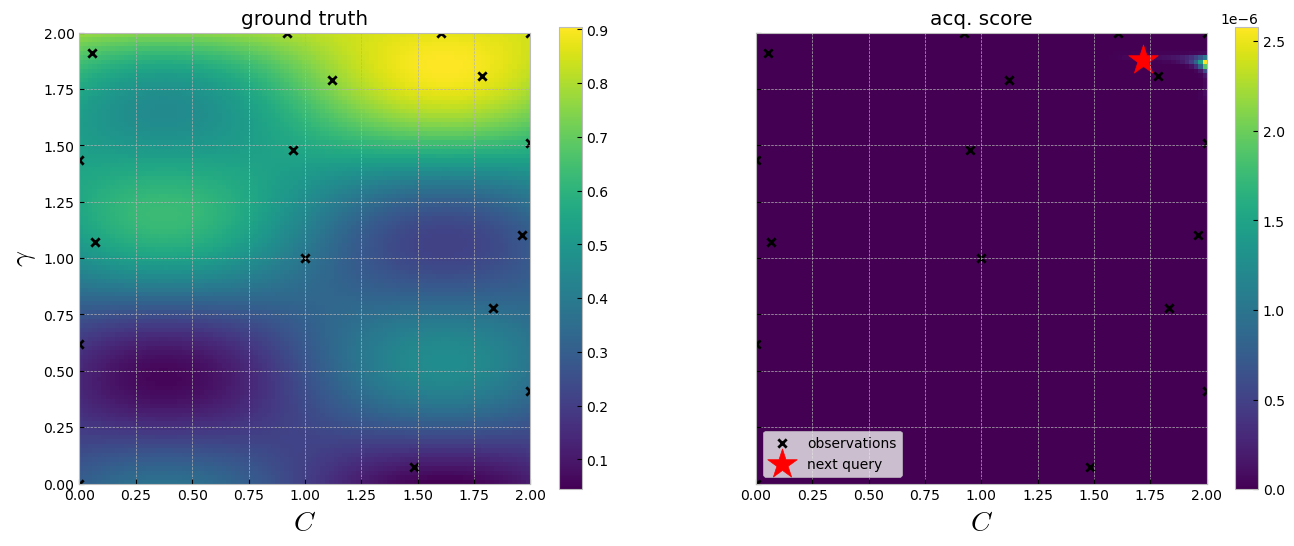

iteration 17
incumbent tensor([1.7157, 1.8789]) tensor(0.9001)


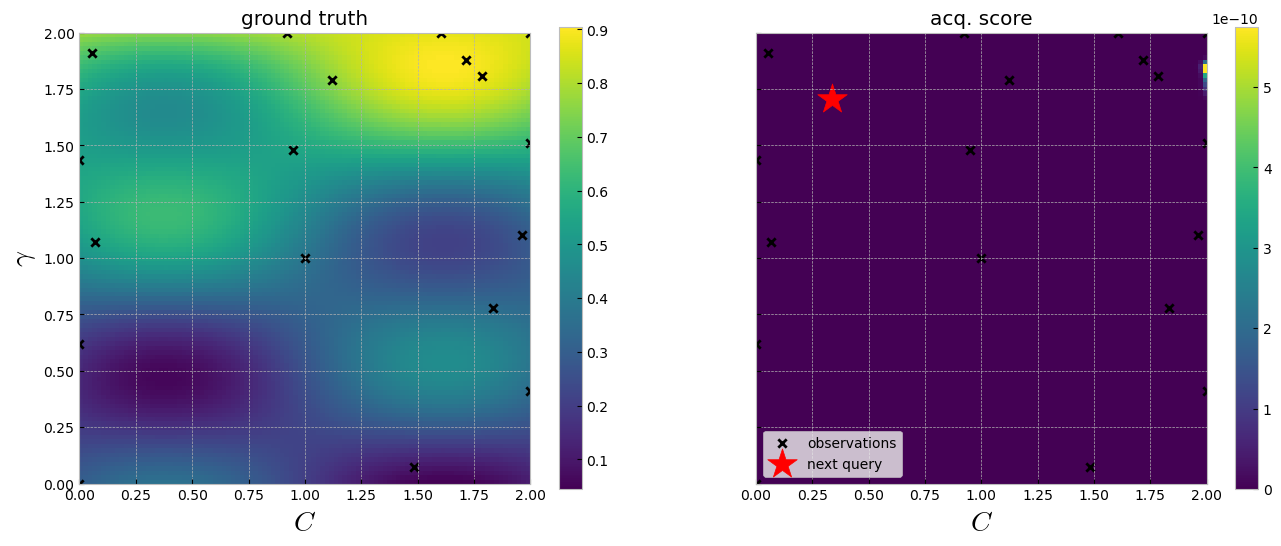

iteration 18
incumbent tensor([1.7157, 1.8789]) tensor(0.9001)


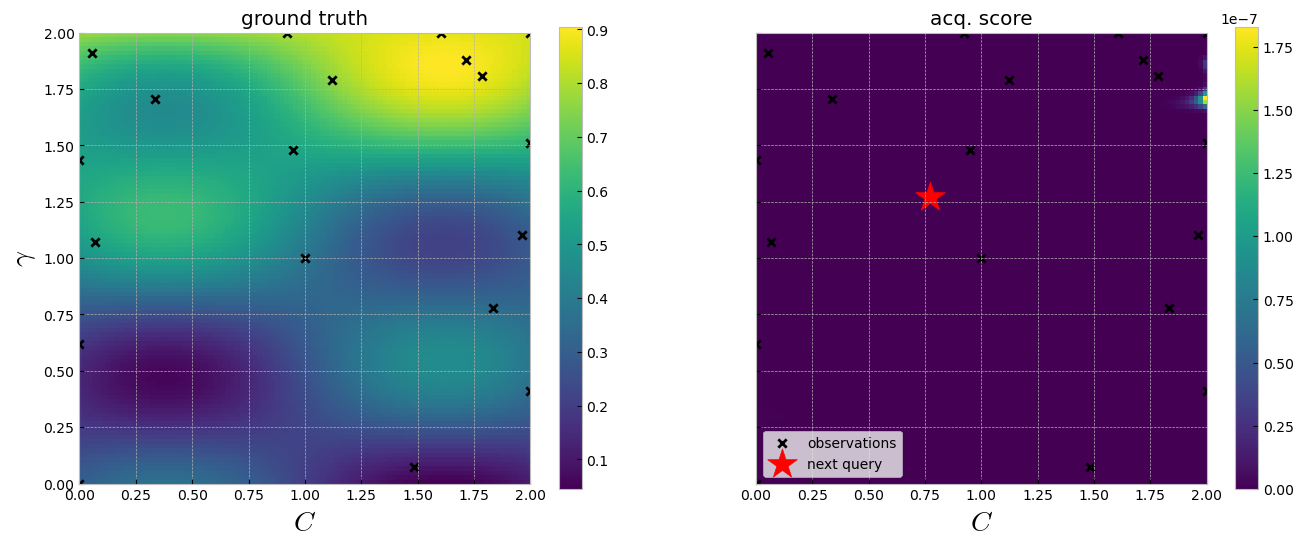

iteration 19
incumbent tensor([1.7157, 1.8789]) tensor(0.9001)


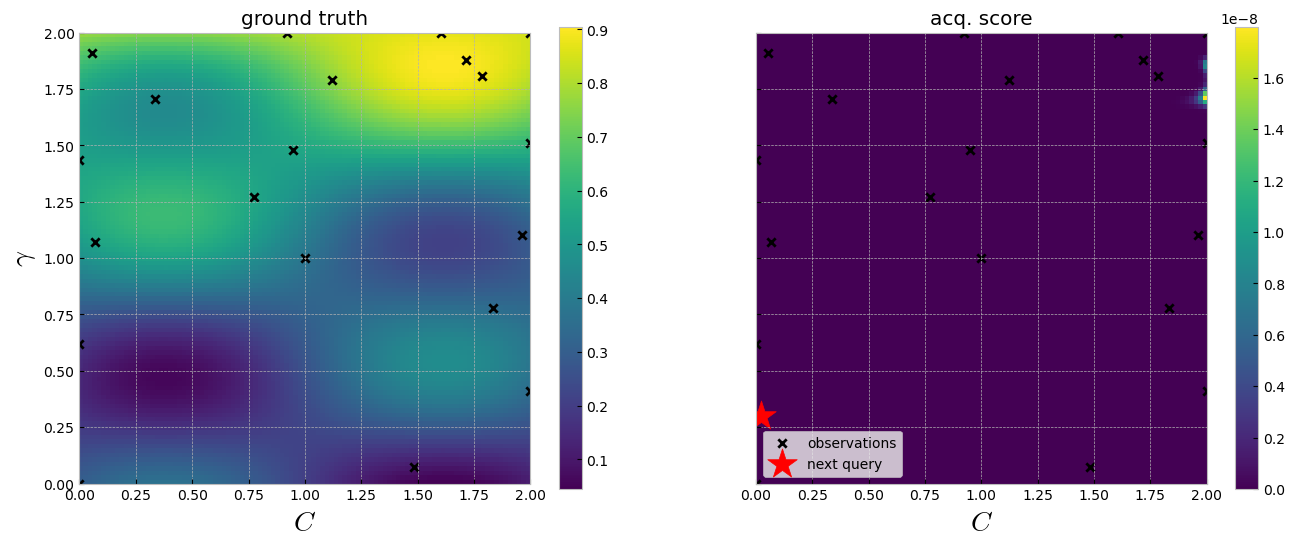

In [6]:
epsilon = 0.1

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max() + epsilon
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100,
    )

    visualize_progress_and_policy(policy, next_x=next_x)

    next_y = f(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

# EI

iteration 0
incumbent tensor([1., 1.]) tensor(0.3800)


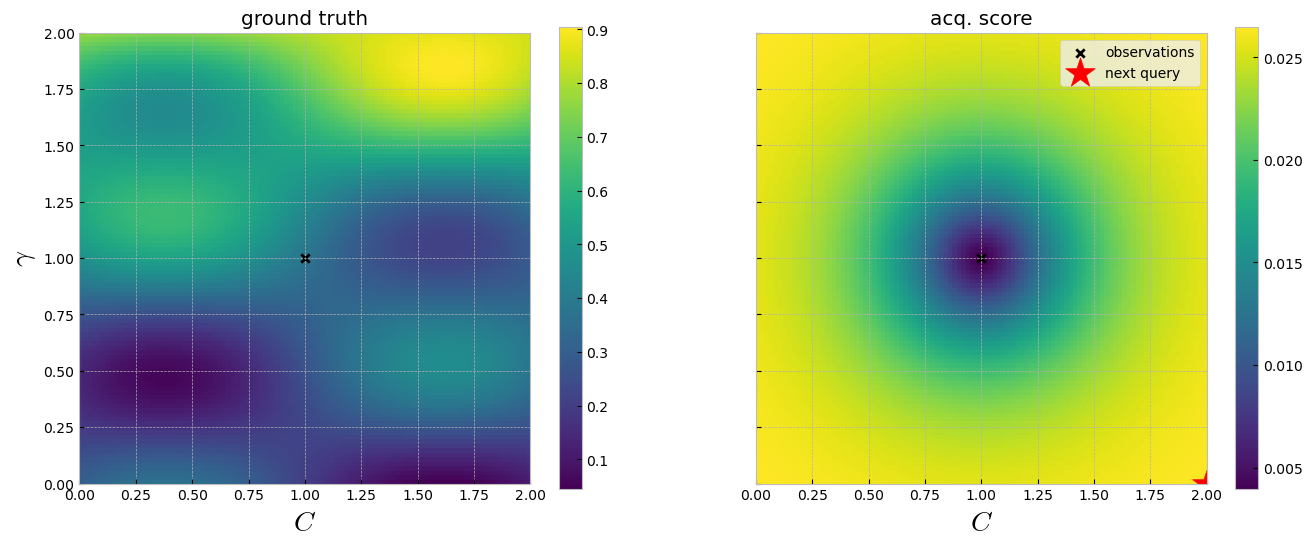

iteration 1
incumbent tensor([1., 1.]) tensor(0.3800)


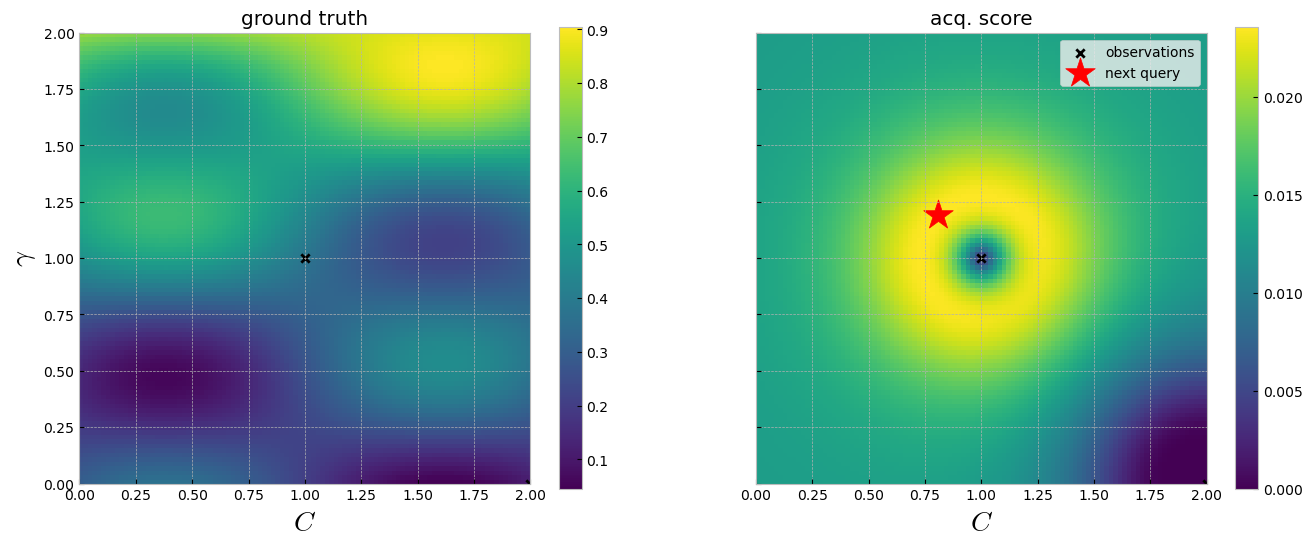

iteration 2
incumbent tensor([0.8074, 1.1914]) tensor(0.5301)


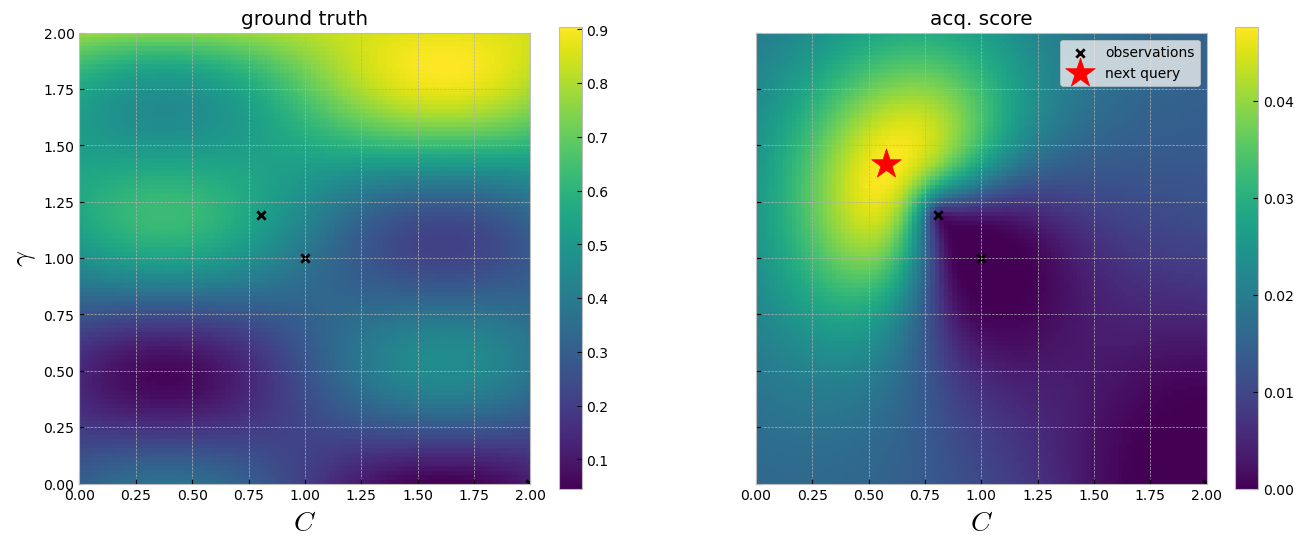

iteration 3
incumbent tensor([0.5790, 1.4188]) tensor(0.5481)


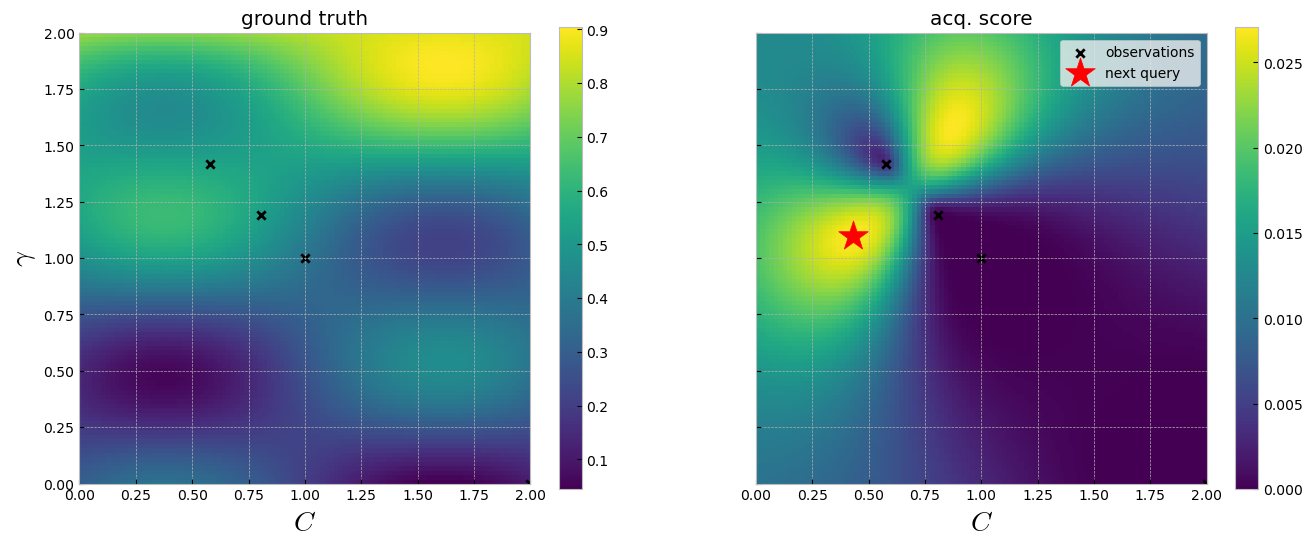

iteration 4
incumbent tensor([0.4306, 1.0975]) tensor(0.6059)


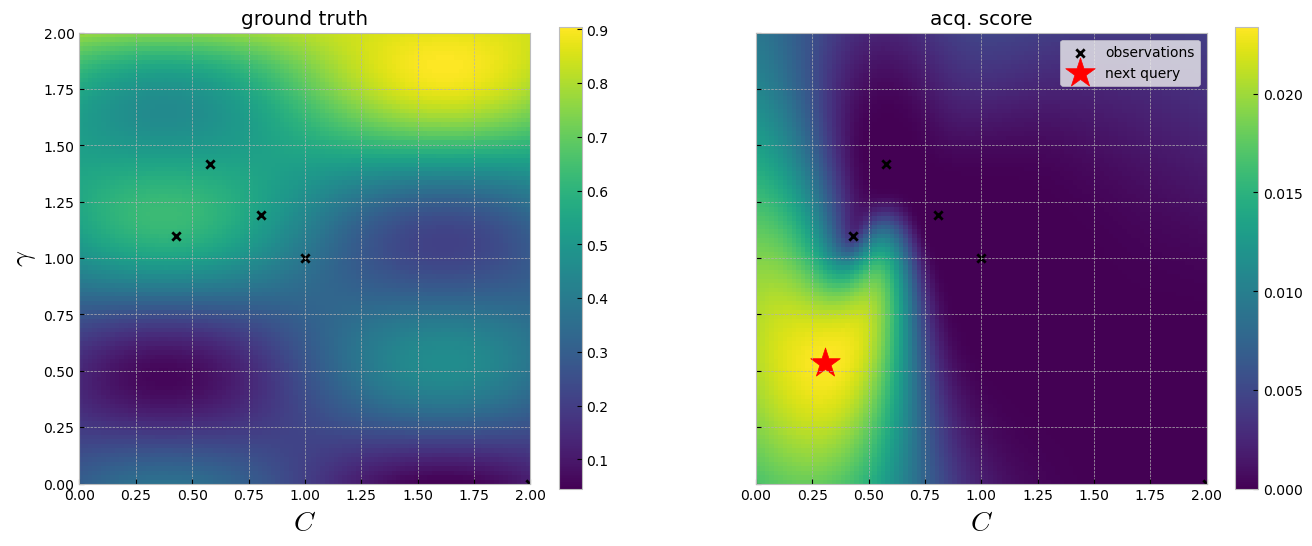

iteration 5
incumbent tensor([0.4306, 1.0975]) tensor(0.6059)


/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/botorch/optim/optimize.py:350: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


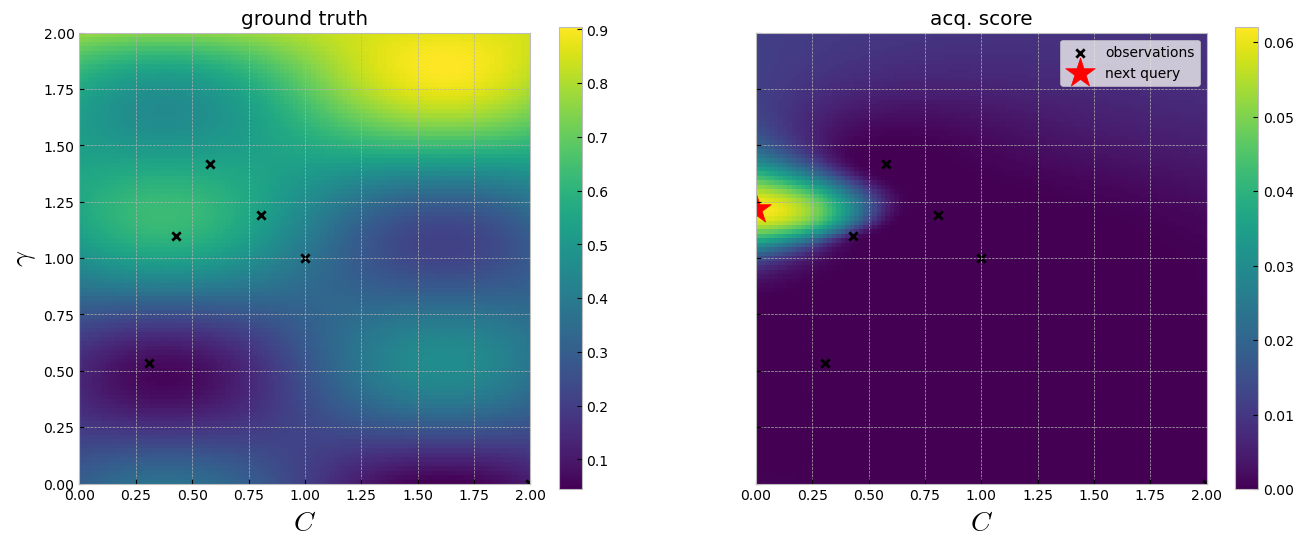

iteration 6
incumbent tensor([0.4306, 1.0975]) tensor(0.6059)


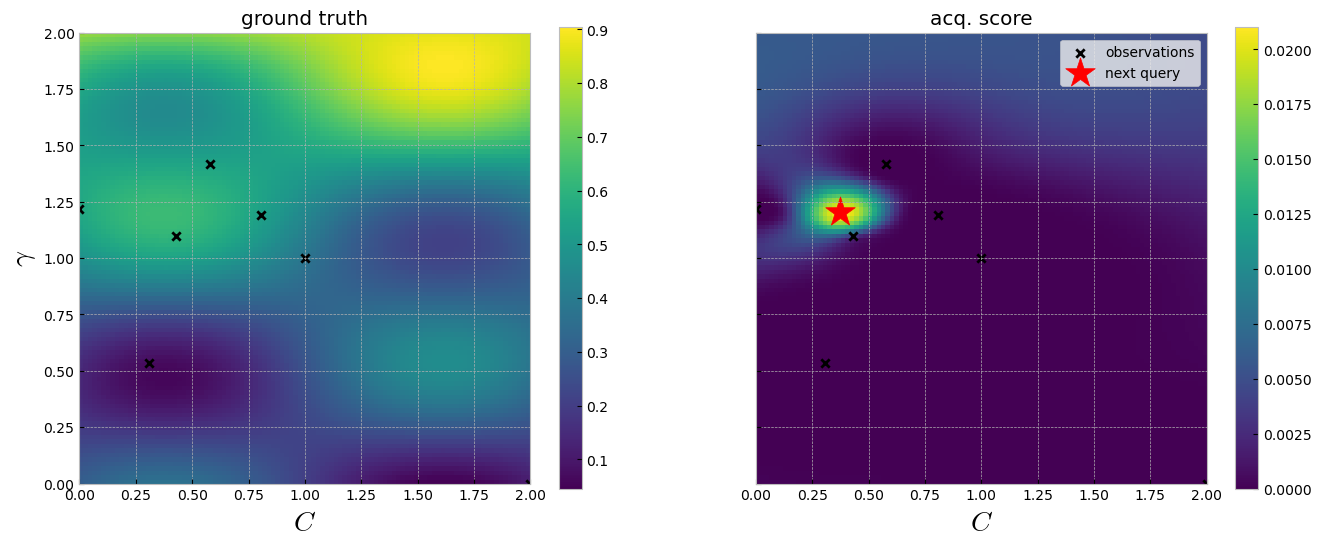

iteration 7
incumbent tensor([0.3751, 1.2056]) tensor(0.6322)


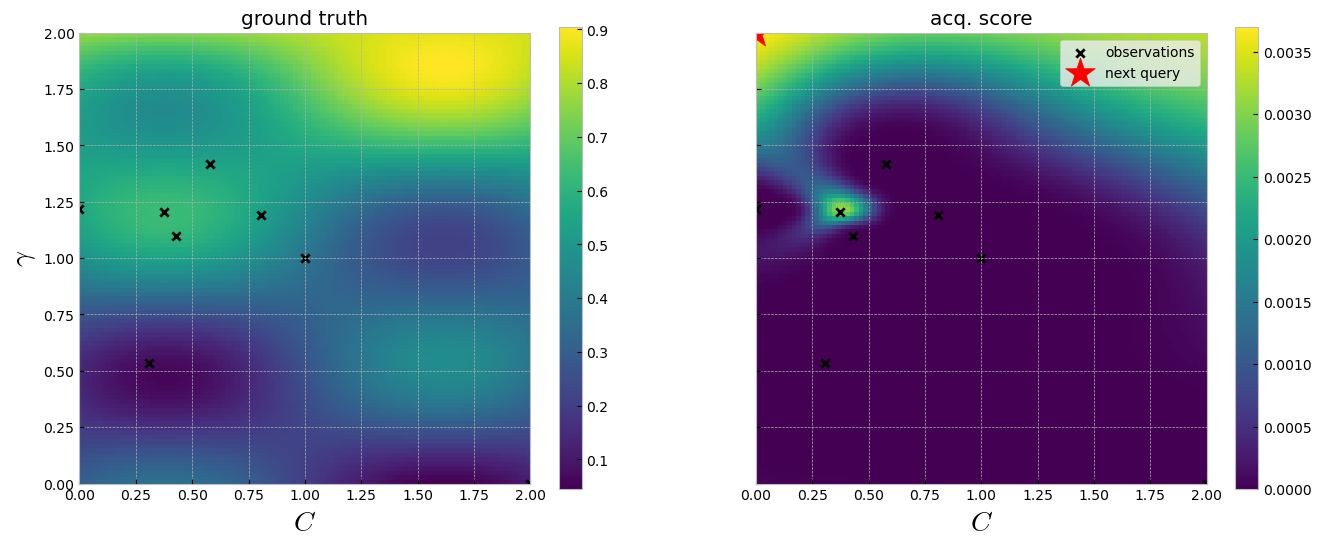

iteration 8
incumbent tensor([0., 2.]) tensor(0.7635)


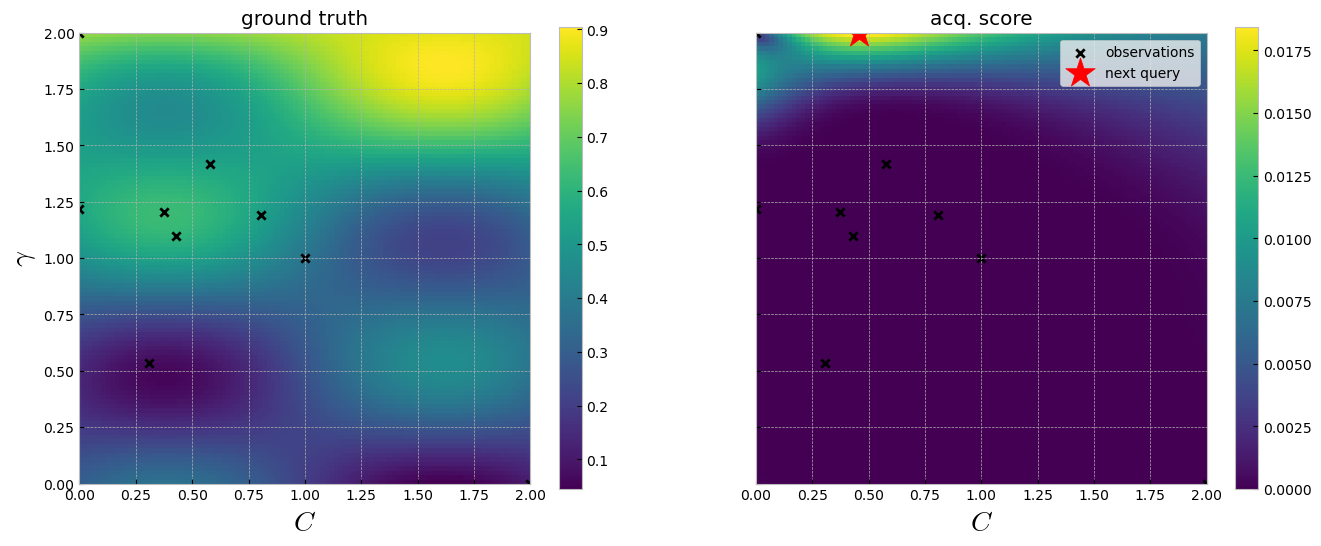

iteration 9
incumbent tensor([0., 2.]) tensor(0.7635)


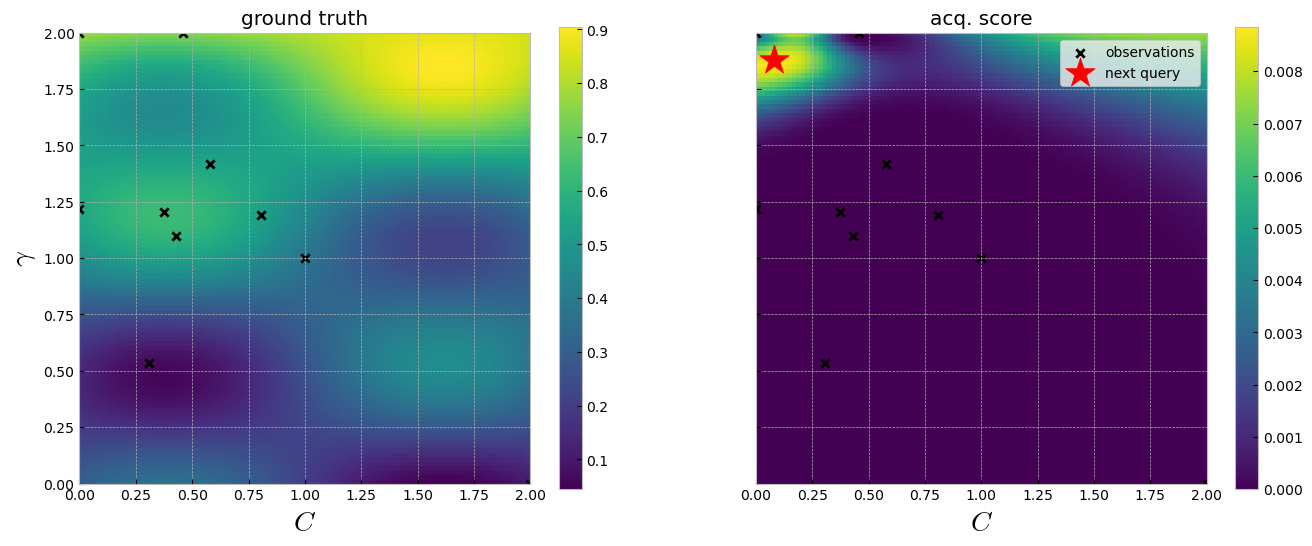

iteration 10
incumbent tensor([0., 2.]) tensor(0.7635)


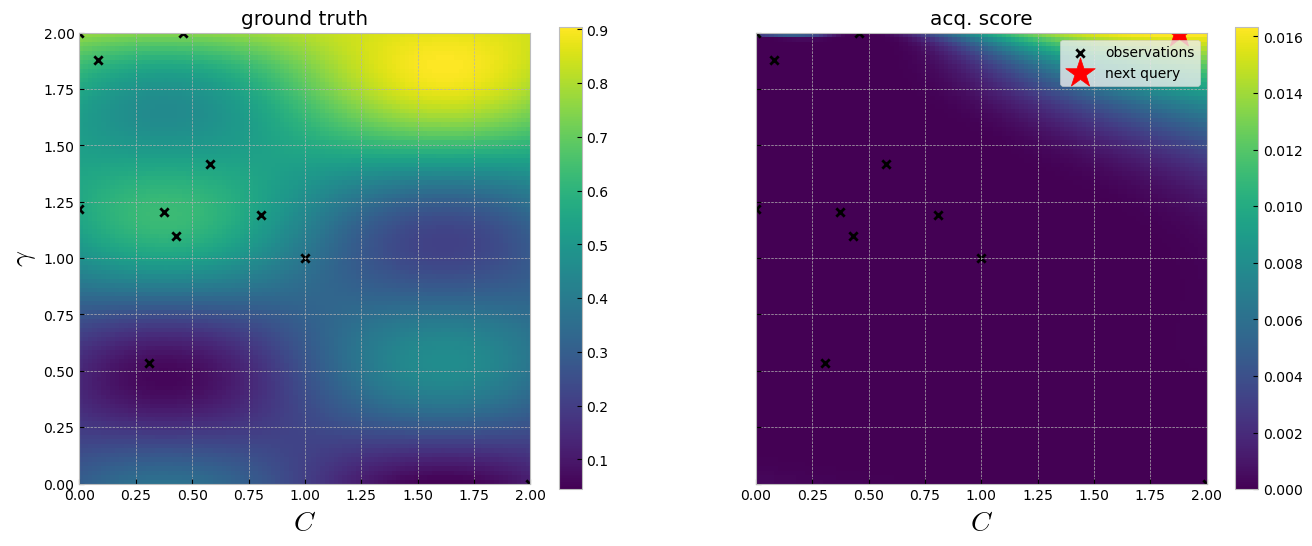

iteration 11
incumbent tensor([1.8764, 2.0000]) tensor(0.8614)


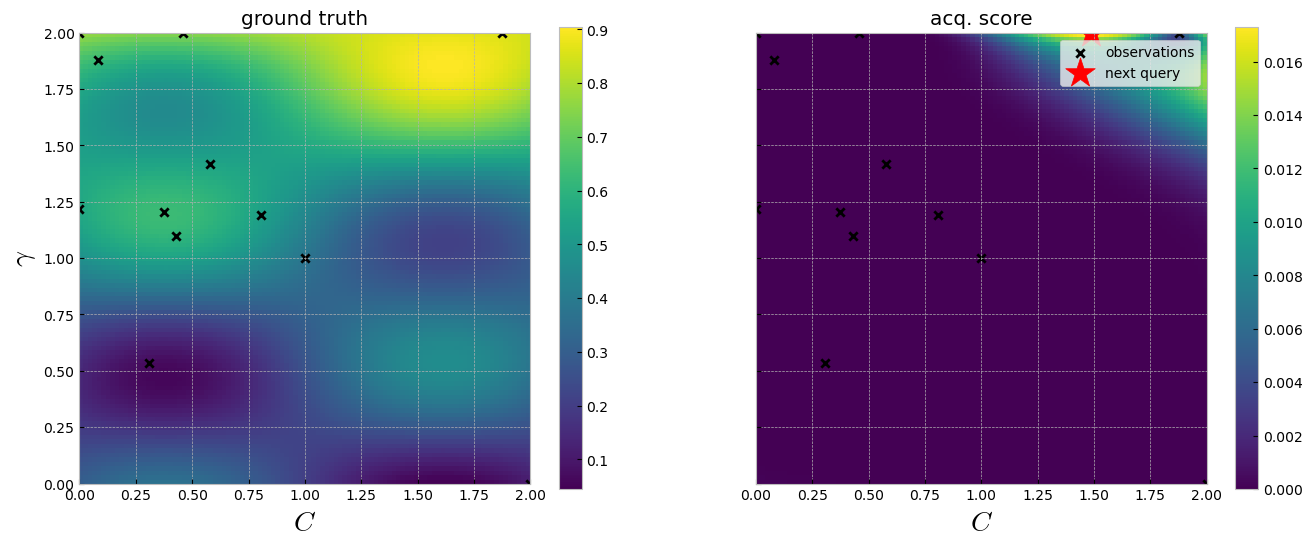

iteration 12
incumbent tensor([1.4871, 2.0000]) tensor(0.8700)


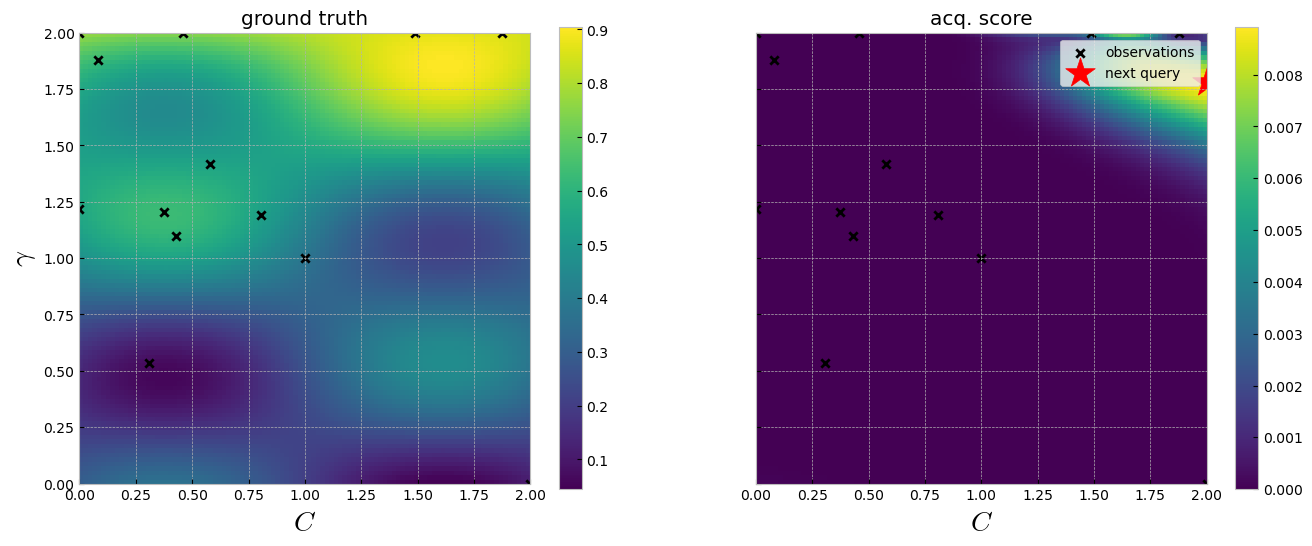

iteration 13
incumbent tensor([1.4871, 2.0000]) tensor(0.8700)


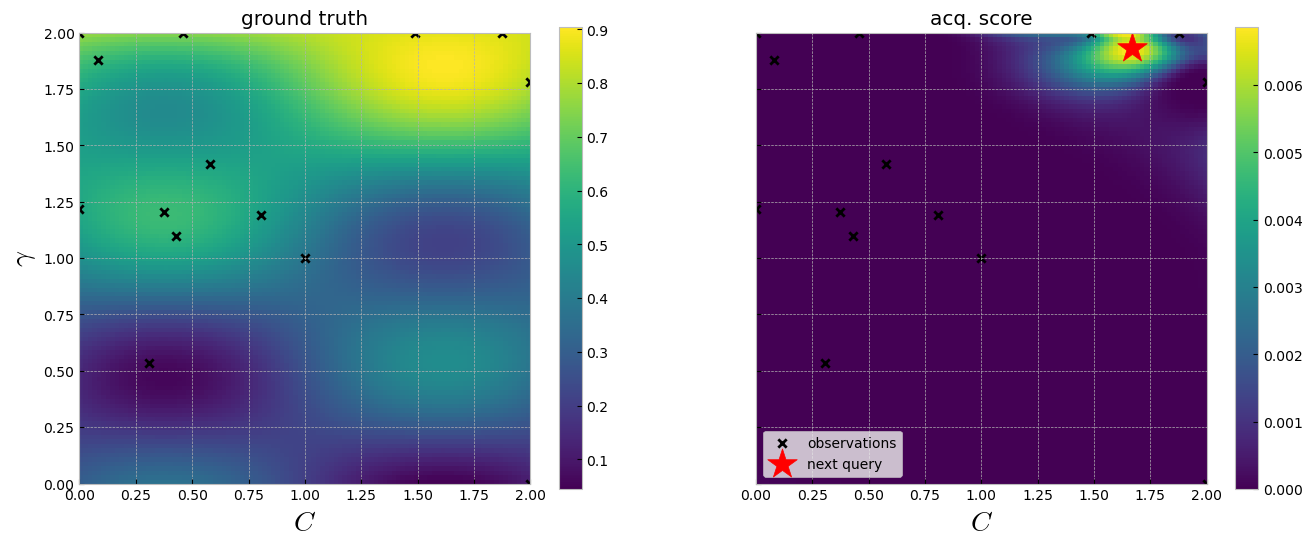

iteration 14
incumbent tensor([1.6684, 1.9321]) tensor(0.8954)


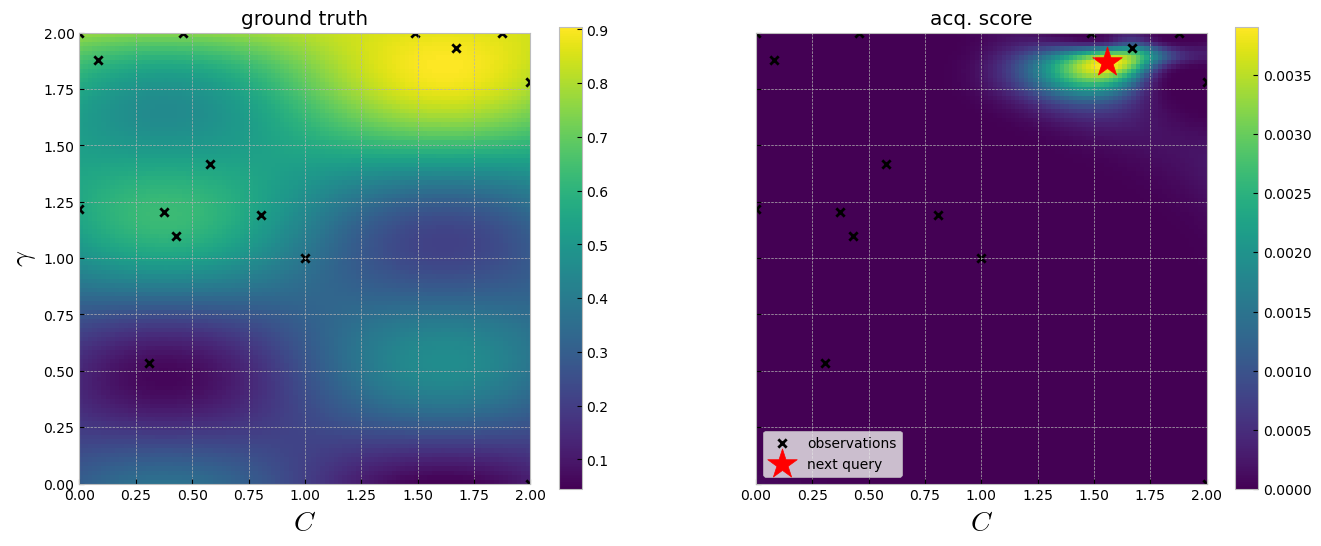

iteration 15
incumbent tensor([1.5585, 1.8695]) tensor(0.9018)


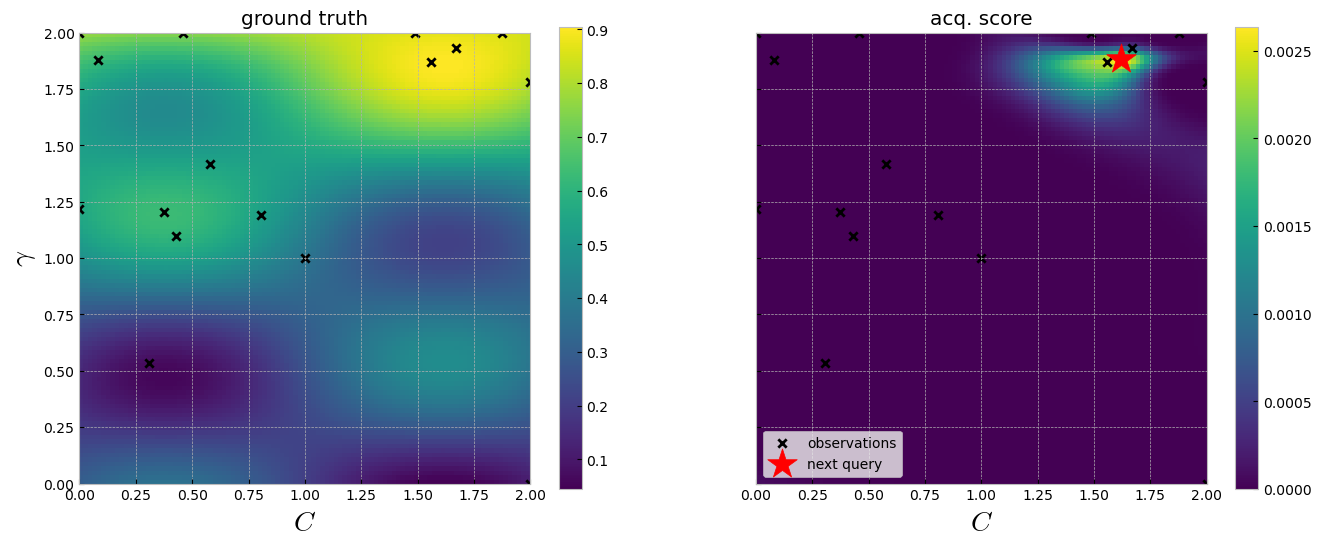

iteration 16
incumbent tensor([1.6201, 1.8854]) tensor(0.9035)


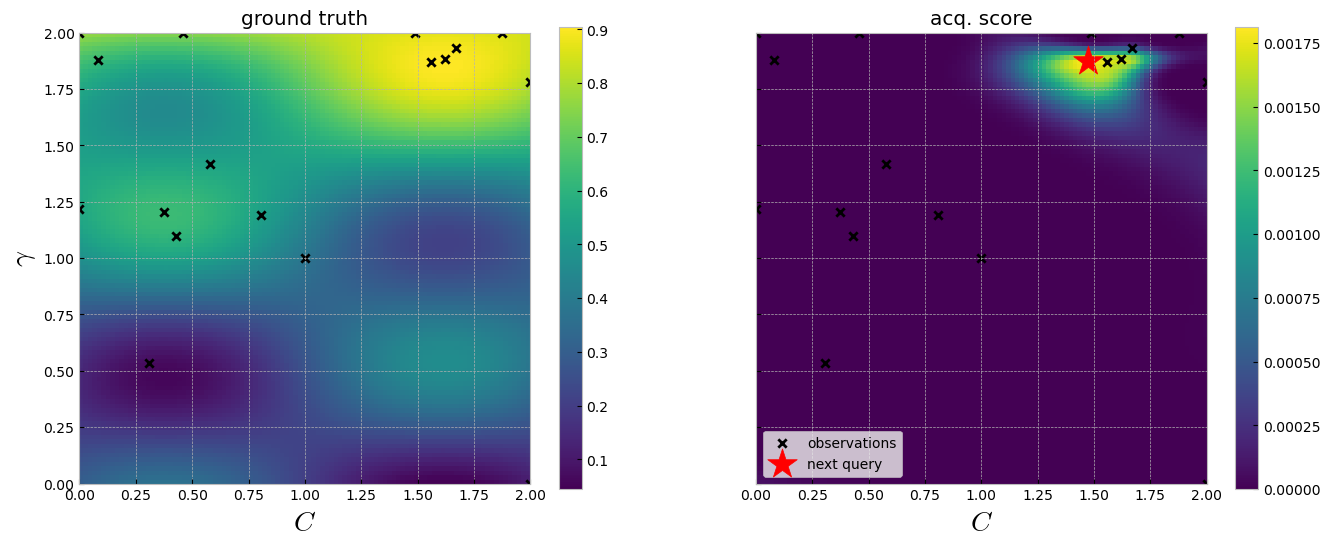

iteration 17
incumbent tensor([1.6201, 1.8854]) tensor(0.9035)


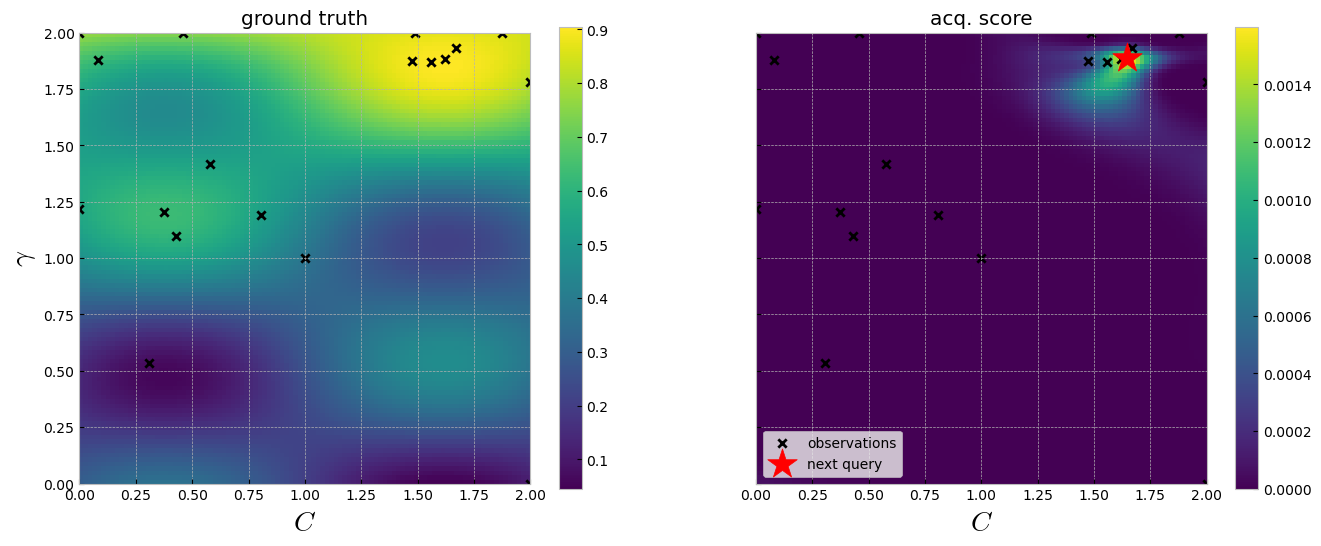

iteration 18
incumbent tensor([1.6201, 1.8854]) tensor(0.9035)


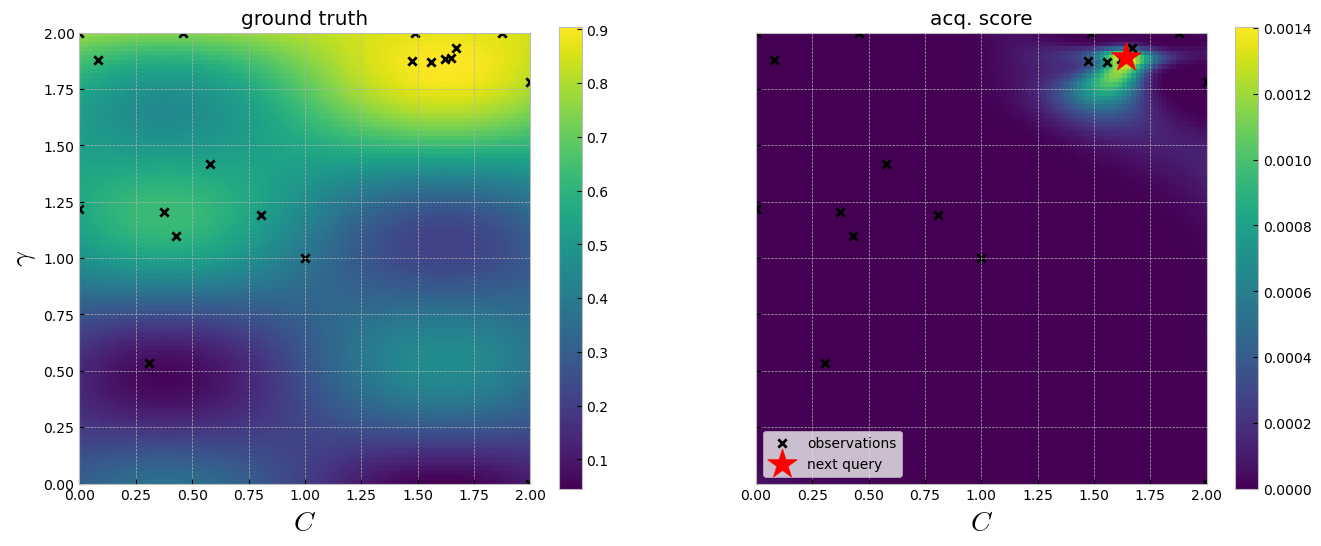

iteration 19
incumbent tensor([1.6201, 1.8854]) tensor(0.9035)


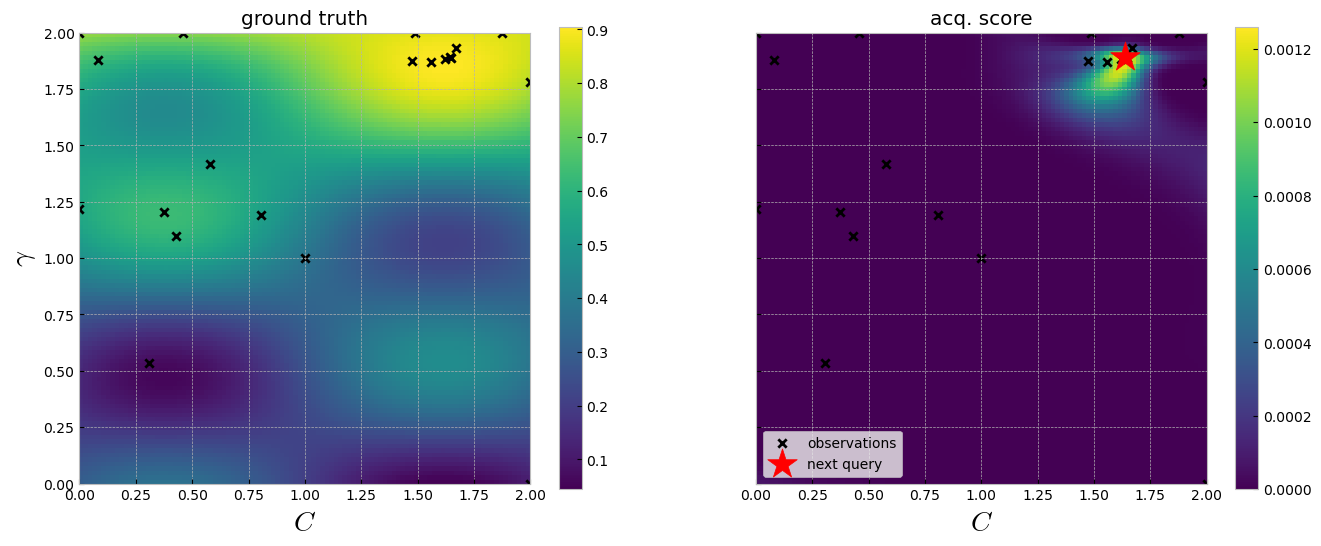

In [6]:
for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ExpectedImprovement(
        model, best_f=train_y.max()
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100,
    )

    visualize_progress_and_policy(policy, next_x=next_x)

    next_y = f(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

# Repeated experiments

In [6]:
# strategy = "poi"
# strategy = "mod_poi"
strategy = "ei"

num_repeats = 10

incumbents = torch.zeros((num_repeats, num_queries))

for trial in range(num_repeats):
    print("trial", trial)

    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
    train_y = f(train_x)

    for i in tqdm(range(num_queries)):
        incumbents[trial, i] = train_y.max()

        model, likelihood = fit_gp_model(train_x, train_y)
        
        if strategy == "poi":
            policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
                model, best_f=train_y.max()
            )
        if strategy == "mod_poi":
            policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
                model, best_f=train_y.max() + 0.1
            )
        if strategy == "ei":
            policy = botorch.acquisition.analytic.ExpectedImprovement(
                model, best_f=train_y.max()
            )
        
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            next_x, acq_val = botorch.optim.optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=40,
                raw_samples=100,
            )

        next_y = f(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

trial 0


  0%|          | 0/20 [00:00<?, ?it/s]

trial 1


  0%|          | 0/20 [00:00<?, ?it/s]

trial 2


  0%|          | 0/20 [00:00<?, ?it/s]

trial 3


  0%|          | 0/20 [00:00<?, ?it/s]

trial 4


  0%|          | 0/20 [00:00<?, ?it/s]

trial 5


  0%|          | 0/20 [00:00<?, ?it/s]

trial 6


  0%|          | 0/20 [00:00<?, ?it/s]

trial 7


  0%|          | 0/20 [00:00<?, ?it/s]

trial 8


  0%|          | 0/20 [00:00<?, ?it/s]

trial 9


  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
torch.save(incumbents, f"../data/hyperparam_tuning/{strategy}.pth")

# Visualization

In [8]:
import numpy as np

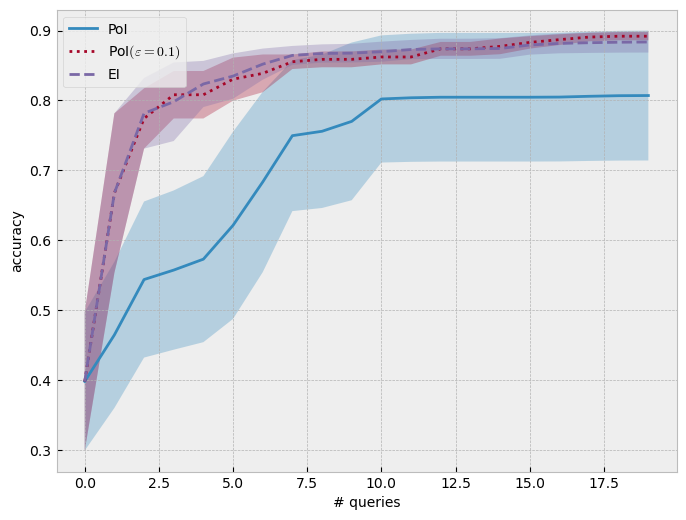

In [11]:
num_repeats = 10


def show_agg_progress(path, name, linestyle="solid"):
    def ci(y):
        return 2 * y.std(axis=0) / np.sqrt(num_repeats)

    incumbents = torch.load(path)
    avg_incumbent = incumbents.mean(axis=0)
    ci_incumbent = ci(incumbents)

    plt.plot(avg_incumbent, linestyle=linestyle, label=name)
    plt.fill_between(
        np.arange(num_queries),
        avg_incumbent + ci_incumbent,
        avg_incumbent - ci_incumbent,
        alpha=0.3,
    )


plt.figure(figsize=(8, 6))

show_agg_progress("../data/hyperparam_tuning/poi.pth", "PoI")
show_agg_progress(
    "../data/hyperparam_tuning/mod_poi.pth",
    "PoI" + r"$(\varepsilon = 0.1)$",
    linestyle="dotted",
)
show_agg_progress("../data/hyperparam_tuning/ei.pth", "EI", linestyle="dashed")

plt.xlabel("# queries")
plt.ylabel("accuracy")

plt.legend()

plt.show()